In [1]:
import re
import pickle
import json
import contextlib
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from typing import Callable, Any
from pathlib import Path
from os import cpu_count
from joblib import load, Parallel, delayed, wrap_non_picklable_objects
from shutil import rmtree
from scipy.stats import binom, norm, chi2, gamma, t, mode, ecdf, gaussian_kde
from scipy.special import betainc
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

# To add

- ES tests
    - Acerbi and Szekely, 2014 -> $Z_3$
- Test for comparing predictions (not necessary)
    - Diebold-Mariano 

# Parameters

The whole notebook will run only on assets included in LLM simulations.
Therefore, it is important for all other methods to include at least these assets.

In [2]:
# Settings to find LLM prediction files
# simulations_directory =  LLM simulations directory (wrapped in Path())
# asset_regex = a regex of file names with a group for the asset name
# window_regex = a regex for the file names with a group on the window size
# glob_pattern = a glob pattern for identifying files; cannot use a regex here, just a limited set of wildcards. Include {asset_name} where it fits.
# results_directory = results directory (wrapped in Path())
# Use 'prediction_type' to choose one particular setting - you shouldn't change here unless predicting on different assets/with different model
llm_simulation_settings = {
    "gpt-3.5-llmtime": {
        "simulations_directory": Path("gpt3.5_simulations"),
        "asset_regex": r".*?_([a-zA-Z0-9]+)_LLMTime(?:_| )GPT-3\.{1,2}5.*",
        "window_regex": r".*_LLMTime(?: |_)GPT-3\.{1,2}5_w=(\d+)",
        "glob_pattern": "*{asset_name}_LLMTime*.csv",
        "results_directory": Path("results/GPT_3.5"),
    },
    "gpt-4-llmtime": {
        "simulations_directory": Path("gpt4_simulations"),
        "asset_regex": r".*?_([a-zA-Z0-9]+)_LLMTime(?:_| )GPT_4.*",
        "window_regex": r".*_LLMTime(?: |_)GPT_4_w=(\d+)",
        "glob_pattern": "*{asset_name}_LLMTime*.csv",
        "results_directory": Path("results/GPT_4"),
    },
    "gpt-4o-llmtime": {
        "simulations_directory": Path("gpt_4o_simulations"),
        "asset_regex": r".*?_([a-zA-Z0-9]+)_LLMTime(?:_| )GPT_4o.*",
        "window_regex": r".*_LLMTime(?: |_)GPT_4o_w=(\d+)",
        "glob_pattern": "*{asset_name}_LLMTime*.csv",
        "results_directory": Path("results/GPT_4o"),
    },
    "o1-mini-generic-prompt": {
        "simulations_directory": Path("llm_o1_tests/o1-mini"),
        "asset_regex": r"generated_samples_temp_([a-zA-Z\d-]+)",
        "window_regex": r"generated_samples_temp_[a-zA-Z\d]+.*_w=(\d+)",
        "glob_pattern": "generated_samples_temp_{asset_name}*",
        "results_directory": Path("results_direct_prompting/o1_generic_prompt"),
    },
    "o1-mini-specialized-prompt": {
        "simulations_directory": Path("llm_o1_tests"),
        "asset_regex": r"generated_samples_temp_([a-zA-Z\d-]+)",
        "window_regex": r"generated_samples_temp_[a-zA-Z\d]+.*_w=(\d+)",
        "glob_pattern": "generated_samples_temp_{asset_name}*",
        "results_directory": Path("results_direct_prompting/o1_specialized_prompt"),
    }
}

In [3]:
# Which model do you want to test? Must define above
prediction_type = "gpt-4-llmtime"
# Original log return data
data_directory = Path("datasets")
# GARCH LPA results main directory, should contain subdirectories for each asset obtained via the python project pylpa
lpa_garch_results_directory = Path("GARCH/LPA")
# Non-LPA GARCH results directory, should contain pickle files for each window
gas_garch_results_directory = Path("GARCH")
# EWMA results directory, should contain pickle files for each window
ewma_results_directory = Path("EWMA")
# Where all results will be saved. This should not be changed
results_directory = llm_simulation_settings[prediction_type]["results_directory"]

# Significance level for VaR, ES, tests
# Must be precomputed for all methods orther than LLM
alpha_VaR = 0.01
alpha_ES = 0.025
# Significance levels for the multinomial test. Must be computed in 'multinomial_test.R', by setting N
multinomial_alphas = [1 - 0.975, 1 - 0.981, 1 - 0.988, 1 - 0.994, 1 - 0.99]
# Student df parameter used for ES testing. Expected to be the same for all estimators
t_nu = 5
# All assets and estimations will start from this date onward
asset_starting_date = pd.Timestamp("2021-10-01 00:00:00")
# Used for consistency in ordering assets at test results
asset_table_ordering = ['CACT', 'DJCI', 'FTSE', 'CRIX', 'CBU', 'SP500', 'STOXX', 'SPGTCLTR', 'GDAXI']

In [4]:
def read_llmtime_assets(prediction_type: str):
    llmtime_assets = set()
    asset_regex = re.compile(llm_simulation_settings[prediction_type]["asset_regex"])
    simulations_directory = llm_simulation_settings[prediction_type]["simulations_directory"]
    for simulations_file in [file for file in simulations_directory.glob("*") if asset_regex.match(file.stem)]:
        llmtime_assets.add(asset_regex.match(simulations_file.stem).group(1))
    
    return list(llmtime_assets)
    
def read_llmtime_simulations(asset: str, prediction_type: str):
    normalized_asset_name = "".join([f"[{char.lower()}{char.upper()}]" for char in asset])
    window_size_regex = re.compile(llm_simulation_settings[prediction_type]["window_regex"])
    simulations_directory = llm_simulation_settings[prediction_type]["simulations_directory"]
    simulation_file_pattern = llm_simulation_settings[prediction_type]["glob_pattern"].format(asset_name=normalized_asset_name)
    llmtime_window_predictions = {}
    
    for simulation_window_file in simulations_directory.glob(simulation_file_pattern):
        window_size = int(window_size_regex.match(simulation_window_file.stem).group(1))
        if simulation_window_file.suffix == ".csv":
            llmtime_window_predictions[window_size] = pd.read_csv(simulation_window_file, parse_dates=["Date"]).set_index("Date") 
        elif simulation_window_file.suffix == ".xlsx":
            llmtime_window_predictions[window_size] = pd.read_excel(simulation_window_file).set_index("Date")
            llmtime_window_predictions[window_size].reset_index().to_csv(simulation_window_file.parent / (simulation_window_file.stem + ".csv"), index=False)
        else:
            raise ValueError("Only csv and Excel simulation files are supported at the moment; you can add more here.")

    return llmtime_window_predictions

def handle_unique_llm_predictions(llmtime_window_predictions: dict[str, dict[int, pd.DataFrame]]):
    llmtime_unique_predictions = {asset: {} for asset in llmtime_assets}
    rng = np.random.default_rng()
    for asset in llmtime_window_predictions.keys():
        for window_size in llmtime_window_predictions[asset].keys():
            test_llmtime_data = llmtime_window_predictions[asset][window_size]
            unique_predictions = test_llmtime_data[test_llmtime_data.nunique(axis=1) == 1]
            if len(unique_predictions) > 0:
                print(f"Asset {asset}, window {window_size}. Found {len(unique_predictions)} LLM predictions with only 1 unique value. Using the last available prediction instead.")
                for unique_prediction_date in unique_predictions.index:
                    unique_prediction_index = test_llmtime_data.reset_index()[test_llmtime_data.reset_index()["Date"] == unique_prediction_date].index[0]
                    # This might be the first index, in which case we search forwards
                    if unique_prediction_index == 0:
                        previous_valid_index = 1
                        while previous_valid_index < len(test_llmtime_data) and test_llmtime_data.iloc[previous_valid_index].index.isin(unique_predictions.index).any():
                            previous_valid_index += 1
                        # If somehow we still haven't found a valid index, then the entire dataset is unique and we raise an error
                        if previous_valid_index == len(test_llmtime_data):
                            raise ValueError(f"There is no non-unique prediction for asset {asset}, window {window_size}.")
                    else:
                        # The previous index might also be unique, so search until we find the first non-unique
                        previous_valid_index = unique_prediction_index - 1
                        while previous_valid_index > 0 and test_llmtime_data.iloc[previous_valid_index].index.isin(unique_predictions.index).any():
                            previous_valid_index -= 1
                        # If we arrive at the first index and found nothing, look forwards
                        if previous_valid_index < 0:
                            previous_valid_index = unique_prediction_index + 1
                        while previous_valid_index < len(test_llmtime_data) and test_llmtime_data.iloc[previous_valid_index].index.isin(unique_predictions.index).any():
                            previous_valid_index += 1
                        # If somehow we still haven't found a valid index, then the entire dataset is unique and we raise an error
                        if previous_valid_index == len(test_llmtime_data):
                            raise ValueError(f"There is no non-unique prediction for asset {asset}, window {window_size}.")
                    # We keep the predicted value by randomnly removing one from the valid day
                    unique_value = test_llmtime_data.iloc[unique_prediction_index, 0]
                    test_llmtime_data.iloc[unique_prediction_index, :] = test_llmtime_data.iloc[previous_valid_index, :]
                    index_to_remove = rng.integers(0, test_llmtime_data.shape[1] - 1, size=1)
                    test_llmtime_data.iloc[unique_prediction_index, index_to_remove] = [unique_value]
                            

def read_original_asset_returns(asset: str):
    normalized_asset_name = "".join([f"[{char.lower()}{char.upper()}]" for char in asset])
    original_prices_file = list(data_directory.glob(f"{normalized_asset_name}.xlsx"))[0]
    original_prices = pd.read_excel(original_prices_file).set_index("Date")
    price_column = "Close" if asset != "stoxx" else "STOXX"
    log_returns = np.log(original_prices[price_column].pct_change() + 1)
    log_returns.fillna(log_returns.iloc[1], inplace=True)
    return log_returns

# Missing data (can skip, it should be solved)

In [649]:
'''
llmtime_missing_data = {asset: {} for asset in llmtime_assets}
for asset in tqdm(llmtime_assets, desc="Computing asset missing data..."):
    try:
        llmtime_asset_data = read_llmtime_simulations(asset)
        original_log_rets = read_original_asset_returns(asset)
        for window in llmtime_asset_data.keys():
            llmtime_window_data = llmtime_asset_data[window]
            llmtime_window_missing_data = (
                original_log_rets.loc[llmtime_window_data.index.min():llmtime_window_data.index.max()].index
                .difference(llmtime_window_data.index)
            )
            if len(llmtime_window_missing_data) > 0:
                llmtime_missing_data[asset][window] = len(llmtime_window_missing_data)
    except Exception as e:
        print(f"Asset {asset}: Error {e}.")
'''

'\nllmtime_missing_data = {asset: {} for asset in llmtime_assets}\nfor asset in tqdm(llmtime_assets, desc="Computing asset missing data..."):\n    try:\n        llmtime_asset_data = read_llmtime_simulations(asset)\n        original_log_rets = read_original_asset_returns(asset)\n        for window in llmtime_asset_data.keys():\n            llmtime_window_data = llmtime_asset_data[window]\n            llmtime_window_missing_data = (\n                original_log_rets.loc[llmtime_window_data.index.min():llmtime_window_data.index.max()].index\n                .difference(llmtime_window_data.index)\n            )\n            if len(llmtime_window_missing_data) > 0:\n                llmtime_missing_data[asset][window] = len(llmtime_window_missing_data)\n    except Exception as e:\n        print(f"Asset {asset}: Error {e}.")\n'

In [650]:
#pd.DataFrame(llmtime_missing_data).fillna(0).astype(int).sort_index()#.rename(index="Window size")

# Read datasets

In [5]:
llmtime_assets = read_llmtime_assets(prediction_type)
asset_table_ordering = [asset_label for asset_label in asset_table_ordering if asset_label in map(str.upper, llmtime_assets)]
llmtime_window_predictions = {asset: read_llmtime_simulations(asset, prediction_type) for asset in tqdm(llmtime_assets, desc="Reading assets...")}
handle_unique_llm_predictions(llmtime_window_predictions)
log_returns_dict = {asset: read_original_asset_returns(asset) for asset in llmtime_assets}

Reading assets...: 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Asset gdaxi, window 30. Found 1 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset ftse, window 30. Found 3 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset cbu, window 120. Found 2 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset cbu, window 150. Found 1 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset cbu, window 30. Found 2 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset cbu, window 45. Found 1 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset cbu, window 90. Found 1 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset SPGTCLTR, window 150. Found 1 LLM predictions with only 1 unique value. Using the last available prediction instead.
Asset SPGTCLTR, window 30. Found 2 LLM predictions wi

In [179]:
garch_lpa_results_dict = {}
garch_lpa_rescaling_dict = {}
garch_lpa_multinomial_results_dict = {}

for asset_results_dir in lpa_garch_results_directory.glob("*"):
    if asset_results_dir.is_dir() and any(asset_results_dir.name.lower().startswith(asset_name.lower()) for asset_name in llmtime_assets):
        with (asset_results_dir / "config.json").open("r") as conf_f:
            config = json.load(conf_f)
        garch_asset_name = config["data"]["path"].split("/")[-1].split(".")[0]
        garch_asset_log_returns = log_returns_dict[garch_asset_name]
        garch_asset_results = pd.read_csv(asset_results_dir / "results.csv", index_col=0, parse_dates=True)
        rounded_alpha_VaR = int(str(round(alpha_VaR, 4))[-1])
        if rounded_alpha_VaR == 0:
            garch_alpha_VaR = round(alpha_VaR, 2)
        else:
            garch_alpha_VaR = round(alpha_VaR, 3)
        garch_asset_VaR = garch_asset_results[f"VaR_{garch_alpha_VaR}"].align(garch_asset_log_returns, join="inner", axis=0)[0].ffill()
        garch_asset_ES = garch_asset_results[f"ES_{alpha_ES:.3f}"].align(garch_asset_log_returns, join="inner", axis=0)[0].ffill()
        # Read volatility
        garch_distribution_means = load(asset_results_dir / "res_cond_means.pkl")
        # Assume only one distribution siht per window - don't fully grasp why, but seems to be working
        garch_lpa_mean_shapes = pd.DataFrame([mean.shape for mean in list(garch_distribution_means.values())]).nunique()
        garch_distribution_vars = load(asset_results_dir / "res_cond_var.pkl")
        garch_lpa_var_shapes = pd.DataFrame([var.shape for var in list(garch_distribution_vars.values())]).nunique()
        # LPA: we assume one distribution per day
        if len(garch_lpa_mean_shapes.shape) > 1:
            print(f"Got {garch_lpa_mean_shapes.shape[0]} different GARCH LPA interval means, expected 1. Will take the first for each observation.")
        if len(garch_lpa_var_shapes.shape) > 1:
            print(f"Got {garch_lpa_var_shapes.shape[0]} different GARCH LPA interval vars, expected 1. Will take the first for each observation.")
        garch_distribution_mean_series = pd.Series(
            data=[mean.iloc[0].iloc[0] for mean in garch_distribution_means.values()], 
            index=garch_asset_log_returns.index[list(garch_distribution_means.keys())],
            name="mean"
        )
        # LPA: we assume zero mean (makes sense because of scaling)
        if not np.allclose(garch_distribution_mean_series, 0):
            print(
                f"{(~np.isclose(garch_distribution_mean_series, 0)).sum() / len(garch_distribution_mean_series):.2%} means are non-zero, expected all to be zero. "
                "Some errors may occur at the ES traffic light test."
            ) 
        garch_distribution_var_series = pd.Series(
            data=[mean.iloc[0].iloc[0] for mean in garch_distribution_vars.values()], 
            index=garch_asset_log_returns.index[list(garch_distribution_vars.keys())],
            name="volatility"
        )
        garch_lpa_results_dict[garch_asset_name] = pd.concat([garch_asset_VaR.rename("VaR"),  -garch_asset_ES.rename("ES"), garch_distribution_var_series], axis=1)
        garch_lpa_VaR_columns = [col for col in garch_asset_results.columns if "VaR" in col]
        garch_lpa_multinomial_results_dict[garch_asset_name] = garch_asset_results[garch_lpa_VaR_columns].align(garch_asset_log_returns, join="inner", axis=0)[0].ffill()

        # Read rescaling mean and std - must use after each operation
        garch_scaling_mean = load(asset_results_dir / "res_means.pkl")
        garch_scaling_mean_series = pd.Series(garch_scaling_mean.values(), index=garch_asset_log_returns.index[list(garch_scaling_mean.keys())])
        garch_scaling_var = load(asset_results_dir / "res_vars.pkl")
        garch_scaling_var_series = pd.Series(garch_scaling_var.values(), index=garch_asset_log_returns.index[list(garch_scaling_var.keys())])
        garch_lpa_rescaling_dict[garch_asset_name] = pd.concat([garch_scaling_mean_series.rename("rescale_mean"), garch_scaling_var_series.rename("rescale_std")], axis=1)

In [180]:
expected_VaR_col, expected_ES_col = f"VaR_{alpha_VaR:.4f}", f"ES_{alpha_ES:.4f}"
ewma_windows = [80, 120]
garch_windows = [120, 250]

ewma_norm_results_dict = {asset: {window: None for window in ewma_windows} for asset in llmtime_assets}
ewma_norm_multinomial_results_dict = {asset: {window: None for window in ewma_windows} for asset in llmtime_assets}
ewma_norm_DCS_results_dict = {asset: {window: None for window in ewma_windows} for asset in llmtime_assets}
ewma_norm_DCS_multinomial_results_dict = {asset: {window: None for window in ewma_windows} for asset in llmtime_assets}
ewma_t_SD_results_dict = {asset: {window: None for window in ewma_windows} for asset in llmtime_assets}
ewma_t_SD_multinomial_results_dict = {asset: {window: None for window in ewma_windows} for asset in llmtime_assets}
for simulations_file in ewma_results_directory.glob("*.pkl"):
    with simulations_file.open("rb") as f:
        ewma_window_results_dict = pickle.load(f)
    window_size = int(re.compile("(\d+)_window").findall(simulations_file.stem)[0])
    for asset in ewma_window_results_dict.keys():
        if asset in llmtime_assets:
            for ewma_type, final_dict_VaR, final_dict_multinomial in zip(
                ["Norm", "DCS", "SD"], 
                [ewma_norm_results_dict, ewma_norm_DCS_results_dict, ewma_t_SD_results_dict],
                [ewma_norm_multinomial_results_dict, ewma_norm_DCS_multinomial_results_dict, ewma_t_SD_multinomial_results_dict],
            ):
                ewma_VaR_columns = [col for col in ewma_window_results_dict[asset][ewma_type].columns if "VaR" in col]
                ewma_norm_asset_result = ewma_window_results_dict[asset][ewma_type][[expected_VaR_col, expected_ES_col, "volatility"]].rename(columns={
                    expected_VaR_col: "VaR", expected_ES_col: "ES"
                }).assign(volatility=lambda df: df["volatility"] ** 2, ES=lambda df: -df["ES"])
                final_dict_VaR[asset][window_size] = ewma_norm_asset_result
                final_dict_multinomial[asset][window_size] = ewma_window_results_dict[asset][ewma_type][ewma_VaR_columns]

garch_norm_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
garch_norm_multinomial_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
garch_t_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
garch_t_multinomial_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
garch_norm_GAS_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
garch_norm_GAS_multinomial_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
garch_t_GAS_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
garch_t_GAS_multinomial_results_dict = {asset: {window: None for window in garch_windows} for asset in llmtime_assets}
for simulations_file in [file for file in gas_garch_results_directory.glob("*.pkl") if len(re.findall(r"_final_", file.name)) > 0]:
    with simulations_file.open("rb") as f:
        garch_window_results_dict = pickle.load(f)
    window_size = int(re.compile("(\d+)_window").findall(simulations_file.stem)[0])
    for asset in garch_window_results_dict.keys():
        if asset in llmtime_assets:
            for garch_type, final_VaR_dict, final_dict_multinomial in zip(
                ["Norm", "T", "GAS", "GAS_T"],
                [garch_norm_results_dict, garch_t_results_dict, garch_norm_GAS_results_dict, garch_t_GAS_results_dict],
                [garch_norm_multinomial_results_dict, garch_t_multinomial_results_dict, garch_norm_GAS_multinomial_results_dict, garch_t_GAS_multinomial_results_dict],
            ):
                garch_VaR_columns = [col for col in garch_window_results_dict[asset][garch_type].columns if "VaR" in col]
                garch_asset_result = garch_window_results_dict[asset][garch_type][[expected_VaR_col, expected_ES_col, "volatility"]].rename(columns={
                    expected_VaR_col: "VaR", expected_ES_col: "ES"
                }).assign(volatility=lambda df: df["volatility"] ** 2, ES=lambda df: -df["ES"])
                final_VaR_dict[asset][window_size] = garch_asset_result
                final_dict_multinomial[asset][window_size] = garch_window_results_dict[asset][garch_type][garch_VaR_columns]

In [181]:
def aggregate_model_predictions(results_dict: dict[str, dict[str, any]]):
    filtered_results_VaR = {}
    filtered_results_ES = {}
    filtered_results_volatility = {}

    for estimator, predictions_dict in results_dict.items():
        estimator_results_VaR, estimator_results_ES, estimator_results_volatility = {}, {}, {}
        for asset, results_dict1 in predictions_dict.items():
            expected = log_returns_dict[asset]
            if isinstance(results_dict1, dict):
                for window_size, predictions in results_dict1.items():
                    aligned_expected, aligned_preds = expected.align(predictions, join="inner", axis=0)
                    aligned_preds = aligned_preds.ffill()
                    if "volatility" in aligned_preds.columns:
                        # GARCH fails for some days and we have volatility 0; here we use the previous day volatility
                        aligned_preds.loc[aligned_preds["volatility"] == 0, "volatility"] = pd.NA
                        aligned_preds["volatility"] =  aligned_preds["volatility"].ffill()
                    if window_size not in estimator_results_VaR.keys():
                        estimator_results_VaR[window_size] = [aligned_preds["VaR"].bfill().rename(asset)]
                        estimator_results_ES[window_size] = [aligned_preds["ES"].bfill().rename(asset)]
                        if "volatility" in predictions.columns:
                            estimator_results_volatility[window_size] = [aligned_preds["volatility"].rename(asset)]
                    else:
                        estimator_results_VaR[window_size].append(aligned_preds["VaR"].bfill().rename(asset))
                        estimator_results_ES[window_size].append(aligned_preds["ES"].bfill().rename(asset))
                        if "volatility" in predictions.columns:
                            estimator_results_volatility[window_size].append(aligned_preds["volatility"].rename(asset))
            else:
                predictions = results_dict1
                aligned_expected, aligned_preds = expected.align(predictions, join="inner", axis=0)
                if "volatility" in aligned_preds.columns:
                        # GARCH fails for some days and we have volatility 0; here we use the previous day volatility
                        aligned_preds.loc[aligned_preds["volatility"] == 0, "volatility"] = pd.NA
                        aligned_preds["volatility"] =  aligned_preds["volatility"].ffill()
                if 0 not in estimator_results_VaR.keys():
                    estimator_results_VaR[0] = [aligned_preds["VaR"].bfill().rename(asset)]
                    estimator_results_ES[0] = [aligned_preds["ES"].bfill().rename(asset)]
                    if "volatility" in predictions.columns:
                            estimator_results_volatility[0] = [aligned_preds["volatility"].rename(asset)]
                else:
                    estimator_results_VaR[0].append(aligned_preds["VaR"].bfill().rename(asset))
                    estimator_results_ES[0].append(aligned_preds["ES"].bfill().rename(asset))
                    if "volatility" in predictions.columns:
                            estimator_results_volatility[0].append(aligned_preds["volatility"].rename(asset))
        
        for window_size in estimator_results_VaR.keys():
            estimator_results_VaR_window = {
                estimator_results.name: estimator_results.loc[asset_starting_date:].ffill()
                for estimator_results in estimator_results_VaR[window_size]
            }
            estimator_results_ES_window = {
                estimator_results.name: estimator_results.loc[asset_starting_date:].ffill()
                for estimator_results in estimator_results_ES[window_size]
            }
            if window_size in estimator_results_volatility.keys():
                estimator_results_volatility_window = {
                    estimator_results.name: estimator_results.loc[asset_starting_date:].ffill()
                    for estimator_results in estimator_results_volatility[window_size]
                }
            missing_assets = set(llmtime_assets) - set(list(estimator_results_VaR_window.keys()))
            if len(missing_assets) == 0:
                if window_size == 0:
                    filtered_results_VaR[estimator] = estimator_results_VaR_window
                    filtered_results_ES[estimator] = estimator_results_ES_window
                    if window_size in estimator_results_volatility.keys():
                        filtered_results_volatility[estimator] = estimator_results_volatility_window
                else:
                    filtered_results_VaR[f"{estimator}_{window_size}"] = estimator_results_VaR_window
                    filtered_results_ES[f"{estimator}_{window_size}"] = estimator_results_ES_window
                    if window_size in estimator_results_volatility.keys():
                        filtered_results_volatility[f"{estimator}_{window_size}"] = estimator_results_volatility_window
            else:
                print(f"Removing {estimator}{', window ' + str(window_size) if window_size > 0 else ''} for assets {list(missing_assets)}.")
        
    return filtered_results_VaR, filtered_results_ES, filtered_results_volatility
        

def estimate_llm_VaR_ES(llmtime_window_predictions: dict[int, pd.Series]):
    # We should compute ES with alpha 0.025, however at this moment we used 0.01 for all other methods
    return {
        window_size: pd.concat([
            window_data.quantile(alpha_VaR, axis=1).rename("VaR"),
            window_data.apply(lambda row: row.sort_values().iloc[:int(alpha_ES * len(row))].mean(), axis=1).rename("ES")
        ], axis=1)
        for window_size, window_data in llmtime_window_predictions.items()
    }

In [182]:
VaR_ES_llmtime_window_predictions = {asset: estimate_llm_VaR_ES(llmtime_window_predictions[asset]) for asset in llmtime_assets}
# Gather all VaRs, ESs, and daily estimated volatilities in one dict of the form {estimator: {window: DataFrame with assets}}
VaR_predictions, ES_predictions, volatility_predictions = aggregate_model_predictions({
    "llmtime": VaR_ES_llmtime_window_predictions,
    "garch_lpa": garch_lpa_results_dict,
    "ewma_normal": ewma_norm_results_dict,
    "ewma_dcs_normal": ewma_norm_DCS_results_dict,
    "ewma_dcs_t": ewma_t_SD_results_dict,
    "garch_normal": garch_norm_results_dict,
    # "garch_t": garch_t_results_dict,
    "garch_dcs_normal": garch_norm_GAS_results_dict,
    "garch_dcs_t": garch_t_GAS_results_dict
})
# Used mostly for ES backtesting
volatility_distributions = {
    "garch_lpa": "normal",
    "ewma_normal": "normal",
    "ewma_dcs_normal": "normal",
    "ewma_dcs_t": "t",
    "garch_normal": "normal",
    # "garch_t": "t",
    "garch_dcs_normal": "normal",
    "garch_dcs_t": "t"
}

In [183]:
negative_ES = {estimator + "_" + asset: preds[preds >= 0].count() for estimator, assets_dict in ES_predictions.items() for asset, preds in assets_dict.items() if (preds >= 0).sum() > 0}
negative_VaR = {estimator + "_" + asset: preds[preds >= 0].count() for estimator, assets_dict in VaR_predictions.items() for asset, preds in assets_dict.items() if (preds >= 0).sum() > 0}

if len(negative_VaR) > 0 or len(negative_ES) > 0:
    negative_VaR_series, negative_ES_series = pd.Series(negative_VaR), pd.Series(negative_ES)
    
    negative_VaR_window = negative_VaR_series.index.map(lambda text: int(text.split("_")[-2]))
    negative_VaR_asset = negative_VaR_series.index.map(lambda text: text.split("_")[-1])
    negative_VaR_sizes = pd.Series([log_returns_dict[asset].iloc[window:].shape[0] for window, asset in zip(negative_VaR_window, negative_VaR_asset)], index=negative_VaR_series.index)
    negative_VaR_percentages = negative_VaR_series / negative_VaR_sizes
    negative_VaR_to_signal = negative_VaR_percentages[negative_VaR_percentages > 0.8]
    if negative_VaR_to_signal.shape[0] > 0:
        raise ValueError(
            f"There are {len(negative_VaR_to_signal)} estimators with more than 80% positive VaR: {negative_VaR_to_signal.index.to_list()}. "
            "Maybe a sign has not been switched (we expect negative VaR and ES)."
        )

    negative_ES_window = negative_ES_series.index.map(lambda text: int(text.split("_")[-2]))
    negative_ES_asset = negative_ES_series.index.map(lambda text: text.split("_")[-1])
    negative_ES_sizes = pd.Series([log_returns_dict[asset].iloc[window:].shape[0] for window, asset in zip(negative_ES_window, negative_ES_asset)], index=negative_ES_series.index)
    negative_ES_percentages = negative_ES_series / negative_ES_sizes
    negative_ES_to_signal = negative_ES_percentages[negative_ES_percentages > 0.8]
    if negative_ES_to_signal.shape[0] > 0:
        raise ValueError(
            f"There are {len(negative_ES_to_signal)} estimators with more than 80% positive ES: {negative_ES_to_signal.index.to_list()}. "
            "Maybe a sign has not been switched (we expect negative VaR and ES)."
        )

# VaR Backtesting

The Traffic Light test, although extensively used in practice, is flawed in regards to _sharpness_, using the framework defined by <cite id="tk8sb"><a href="#zotero%7C12595123%2FA9UGX7MM">(Acerbi &#38; Székely, 2023)</a></cite>.

Sharpness is defined as: given two prediction scores, one better than the other, is the ranking proposed by the backtest lower for the former?

Therefore, we turn to other tests:
- Kupiec's Proportion of Failures (POF) test with the most powerful formulation
- Christoffersen's Conditional Coverage test

Both tests have been modified to work for no exceedance according to the binomial probability of zero such events.

Important to note, howerver, that *VaR in general is not considered backtestable as per the framework developed in this study*.

In [120]:
class Backtest:
    def __init__(self, actual: pd.Series, VaR: pd.Series, ES: pd.Series, alpha: float):
        actual, VaR = actual.align(VaR, join="inner", axis=0)
        # VaR, ES = VaR.align(ES, join="inner", axis=0)
        if actual.index.difference(ES.index).shape[0] > 0 or ES.index.difference(actual.index).shape[0] > 0:
            raise ValueError("Actual vs ES do not have the same index")
        self.actual = actual
        self.index = self.actual.index
        self.forecast = VaR.values

        self.ES = ES.values
        self.actual = self.actual.values
        self.alpha = alpha


    def hit_series(self):
        return (self.actual < self.forecast) * 1

    def three_zone_thresholds(self, N):
        p = 0.99
        n_exceptions = range(0, 20 + 1)
        cumulative_probability = np.array([
            1 - binom.cdf(N - exceptions - 1, N, p)
            for exceptions in n_exceptions
        ])
        
        return (
            np.abs(cumulative_probability - 0.95).argmin(),
            np.abs(cumulative_probability - 0.9999).argmin()
        )
    
    def three_zone_test(self, sample_size):
        hit_series = pd.Series(self.actual < self.forecast)
        three_zone_hits = hit_series.sample(n=sample_size, replace = False).sum()
        thresholds = self.three_zone_thresholds(sample_size)
        # print(f"Determined thresholds: {thresholds}.")
        if three_zone_hits < thresholds[0]:  
            color = "Green"
        elif three_zone_hits < thresholds[1]:
            color = "Amber"
        else:
            color = "Red"

        return three_zone_hits, color

    def number_of_hits(self):
        return self.hit_series().sum()

    def hit_rate(self):
        return self.hit_series().mean()

    def expected_hits(self):
        return self.actual.size * self.alpha
    
    def traffic_light_normal_test(self):
        N = len(self.actual)

        if N * self.alpha < 5 or N * (1 - self.alpha) < 5:
            wrong_result = N * self.alpha if N * self.alpha < 5 else N * (1 - self.alpha)
            wrong_result_type = "N * alpha" if N * self.alpha < 5 else "N * (1 - alpha)"
            print(f"Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got {wrong_result_type} = {wrong_result:.2f}. Use the binomial test.")
  
        N_fail = self.hit_series().sum()
        z=(N_fail - N * self.alpha) / np.sqrt(N * self.alpha * (1 - self.alpha))
        
        p_value = norm.cdf(z)
        return pd.Series(
            [z, p_value],
            index=["Statistic", "percentage"], 
            name="Traffic light multinomial Test"
        )

    def traffic_light_binomial_test(self):
        N = len(self.actual)
  
        N_fail = self.hit_series().sum()
        p_value = 1 - binom.cdf(N_fail, N, self.alpha)
        percentage = binom.cdf(N_fail, N, self.alpha)
        expected_failures = N * self.alpha
        
        return pd.Series(
            [p_value, percentage, expected_failures],
            index=["p-value", "percentage", "expected_losses"], 
            name="Traffic light binomial Test"
        )
    

    def kupiec_test(self):
        """
        Kupiec Proportion of Failures (POF) test for Value at Risk (VaR) models.
        """
        # Total number of observations
        N = len(self.actual)
        
        # Number of VaR exceedances (failures)
        x = self.hit_series().sum()  # Number of failures
        
        # VaR level (alpha) and p = VaR level
        p = self.alpha  # p is the VaR level, typically set as 0.01 for 99% VaR
    
        # Non-failures (n0)
        n0 = N - x
        
        # Handle edge cases
        if x == 0:
            # No failures: Simplified likelihood ratio when x = 0
            if p == 1:
                LR_POF = 0  # If p is 1, the test makes no sense since p=1 implies guaranteed failure
            else:
                LR_POF = -2 * N * np.log(1 - p)
        elif x == N:
            # All failures: Simplified likelihood ratio when x = N
            if p == 0:
                LR_POF = 0  # If p is 0, the test would imply guaranteed success
            else:
                LR_POF = -2 * N * np.log(p)
        else:
            # General case: some failures and some non-failures
            pi_obs = x / N  # Observed proportion of failures
            LR_POF = -2 * (x * np.log(p) + n0 * np.log(1 - p) - x * np.log(pi_obs) - n0 * np.log(1 - pi_obs))
        
        # Compute p-value from the chi-squared distribution with 1 degree of freedom
        p_value = 1-chi2.cdf(LR_POF, df=1)
        
        # Expected number of failures
        expected_failures = N * p  # Expected failures based on VaR level (p)
        
        # Return a pandas Series containing the Kupiec test p-value, LR_POF, and expected failures
        return pd.Series(
            [p_value, LR_POF, expected_failures],
            index=["p-value", "LR_POF", "Expected Failures"], 
            name="Kupiec Test"
        )



    def plot(self, ax=None, plot_ES=False, file_name=None):
    
        # Re-add the time series index
        r = pd.Series(self.actual, index=self.index)
        q = pd.Series(self.forecast, index=self.index)
        ES = pd.Series(self.ES, index=self.index)

        # sns.set_context("paper")
        # sns.set_style("white", {"font.family": "serif", "font.serif": "Computer Modern Roman", "text.usetex": True})

        # Hits
        if ax is None:
            plt.figure(figsize=(20, 10))
            ax = plt.gca()

        if (r <= q).any():
            r[r <= q].plot(color="red", marker="o", ls="None", ax=ax)

        for h in r[r <= q].index:
            ax.axvline(h, color="black", alpha=0.4, linewidth=1, zorder=0)

        # Positive returns
        r[q < r].plot(ax=ax, color="green", marker="o", ls="None")

        # Negative returns but no hit
        r[(q <= r) & (r <= 0)].plot(ax=ax, color="orange", marker="o", ls="None")

        # VaR
        q.plot(ax=ax, grid=False, color="black", rot=0)

        # ES
        if plot_ES:
            ES.plot(ax=ax, grid=False, color=plt.get_cmap("tab10")(0), linestyle="--")

        # Axes
        ax.set_xlabel("")
        ax.set_ylabel("Log Returns")
        ax.yaxis.grid()

        # sns.despine()
        # if file_name is None:
        #     plt.show()
        if file_name is not None:
            plt.savefig(file_name, bbox_inches="tight")
        # plt.close("all")

    def exceedence_types(self):
        hits = self.hit_series()   # Hit series
        tr = hits[1:] - hits[:-1]  # Sequence to find transitions

        # Transitions: nij denotes state i is followed by state j nij times
        n01, n10 = (tr == 1).sum(), (tr == -1).sum()
        n11, n00 = (hits[1:][tr == 0] == 1).sum(), (hits[1:][tr == 0] == 0).sum()

        return n00, n01, n10, n11

    def VaR_failure_rate(self):
        hits = self.hit_series()

        return hits.sum() / self.actual.shape[0]


    
    def lr_bt(self):
        """Likelihood ratio framework of Christoffersen (1998)"""
        
        # Get the hit series of 0s and 1s (failures and no failures)
        hits = self.hit_series()
        
        # Total number of observations
        n = len(hits)
        
        # Check if there are any failures
        if hits.sum() == 0:  # No failures at all
            # Unconditional Coverage Test for no failures
            uc_h0 = n * np.log(1 - self.alpha)  # All observations are non-failures
            
            # Handle case of no failures (p = 0), uc_h1 becomes 0 since log(0) is undefined
            uc_h1 = 0
            
            # Unconditional Coverage likelihood ratio
            uc = -2 * (uc_h0 - uc_h1)
            
            # Compute p-value from chi-squared distribution with 1 degree of freedom for UC test
            p_value_uc = 1 - chi2.cdf(uc, df=1)
            
            # No independence to test, LR_CCI = 0
            ind = 0
            p_value_ind = 1.0  # p-value is 1, as there's no evidence of dependence
            
            # Conditional Coverage LR_CC = LR_POF in this case
            cc = uc
            p_value_cc = p_value_uc
            
            # Create a DataFrame with the results
            df = pd.DataFrame({
                "Statistic": [uc, ind, cc],
                "p-value": [p_value_uc, p_value_ind, p_value_cc]
            }, index=["Unconditional", "Independence", "Conditional"])
        
        else:
            # Calculate transition probabilities if there are failures
            tr = hits[1:] - hits[:-1]  # Sequence to find transitions between states
    
            # Transitions: nij denotes state i followed by state j, nij times
            n01 = (tr == 1).sum()  # No failure followed by failure
            n10 = (tr == -1).sum()  # Failure followed by no failure
            n11 = (hits[1:][tr == 0] == 1).sum()  # Failure followed by failure
            n00 = (hits[1:][tr == 0] == 0).sum()  # No failure followed by no failure
    
            # Times in the states
            n0 = n01 + n00  # Periods with no failures
            n1 = n10 + n11  # Periods with failures
            
            # Total number of periods
            n = n0 + n1
            
            # Probabilities of transitions from one state to another
            p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
            p11 = n11 / (n11 + n10) if (n11 + n10) > 0 else 0
            p = n1 / n if n > 0 else 0
            
            # Unconditional Coverage (UC)
            uc_h0 = n0 * np.log(1 - self.alpha) + n1 * np.log(self.alpha) if self.alpha > 0 else 0
            uc_h1 = n0 * np.log(1 - p) + n1 * np.log(p) if p > 0 else 0
            uc = -2 * (uc_h0 - uc_h1)
    
            # Independence (IND)
            ind_h0 = (n00 + n10) * np.log(1 - p) + (n01 + n11) * np.log(p) if p > 0 else 0
            ind_h1 = n00 * np.log(1 - p01) + n01 * np.log(p01) + n10 * np.log(1 - p11)
            if p11 > 0:
                ind_h1 += n11 * np.log(p11)
            ind = -2 * (ind_h0 - ind_h1)
    
            # Conditional Coverage (CC)
            cc = uc + ind
            
            # Compute p-values
            p_value_uc = 1 - chi2.cdf(uc, df=1)
            p_value_ind = 1 - chi2.cdf(ind, df=1)
            p_value_cc = 1 - chi2.cdf(cc, df=2)
            
            # Stack results into a DataFrame
            df = pd.DataFrame({
                "Statistic": [uc, ind, cc],
                "p-value": [p_value_uc, p_value_ind, p_value_cc]
            }, index=["Unconditional", "Independence", "Conditional"])
        
        return df



In [121]:
VaR_backtest_dict = {
    estimator: {
        asset: Backtest(actual=log_returns_dict[asset], VaR=VaR_predictions[estimator][asset], ES=ES_predictions[estimator][asset], alpha=alpha_VaR)
        for asset in VaR_predictions[estimator].keys()
    }
    for estimator in VaR_predictions.keys()
}

In [122]:
backtest_failure_rates = {}
backtest_traffic_light_normal = {}
backtest_traffic_light_binomial = {}
backtest_kupiec = {}
backtest_christoffersen = {}

for estimator, assets in VaR_backtest_dict.items():
    estimator_failure_rates = {}
    estimator_traffic_light_normal = {}
    estimator_traffic_light_binomial = {}
    estimator_kupiec = {}
    estimator_christoffersen = {}
    for asset_name, model in assets.items():
        # print(estimator, asset_name)
        estimator_failure_rates[asset_name] = model.VaR_failure_rate()
        estimator_traffic_light_normal[asset_name] = model.traffic_light_normal_test()["percentage"]
        estimator_traffic_light_binomial[asset_name] = model.traffic_light_binomial_test()["percentage"]
       
        christoffersen_result_series = model.lr_bt()

        estimator_christoffersen[asset_name] = christoffersen_result_series.loc["Conditional", "p-value"]
        estimator_kupiec[asset_name] = model.kupiec_test()["p-value"]
        
    backtest_failure_rates[estimator] = pd.DataFrame.from_dict(estimator_failure_rates, orient="index").iloc[:, 0].rename(estimator)
    backtest_traffic_light_normal[estimator] = pd.DataFrame.from_dict(estimator_traffic_light_normal, orient="index").iloc[:, 0].rename(estimator)
    backtest_traffic_light_binomial[estimator] = pd.DataFrame.from_dict(estimator_traffic_light_binomial, orient="index").iloc[:, 0].rename(estimator)
    backtest_kupiec[estimator] = pd.DataFrame.from_dict(estimator_kupiec, orient="index").iloc[:, 0].rename(estimator)
    backtest_christoffersen[estimator] = pd.DataFrame.from_dict(estimator_christoffersen, orient="index").iloc[:, 0].rename(estimator)

Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got N * alpha = 4.86. Use the binomial test.
Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got N * alpha = 4.99. Use the binomial test.
Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got N * alpha = 4.84. Use the binomial test.
Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got N * alpha = 4.96. Use the binomial test.
Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got N * alpha = 4.96. Use the binomial test.
Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got N * alpha = 4.56. Use the binomial test.
Traffic light normal approximation: Possibly wrong results, too few observations. Expected at least 5, got N * a

In [80]:
import pandas as pd

# Assuming backtest_failure_rates is already defined and populated
failure_rates_df = pd.DataFrame.from_dict(backtest_failure_rates, orient="index")

# Multiply by 100 to convert to percentages
failure_rates_df = failure_rates_df * 100

# Round the DataFrame to 3 decimal places
failure_rates_df = failure_rates_df.round(3)

# Convert columns to uppercase and replace "NORMAL" with "N"
failure_rates_df.columns = failure_rates_df.columns.str.upper().str.replace("NORMAL", "N")

# Reorder columns for consistency
failure_rates_df = failure_rates_df[asset_table_ordering]

# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
failure_rates_df.index = (failure_rates_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val <= 1:
            if val < 0.5:
                color = "green!30!white"  # Ligther green
            else:
                color = "green!70!white"  # Darker green 
        else:
            if val < 0.01:
                color = "red!30!white"  # Lighter
            else:
                color = "red!70!white"  # Darker
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")



# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(failure_rates_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in failure_rates_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 3 decimal formatting and color coding
for idx, row in failure_rates_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([format_value(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Write the LaTeX code to a .tex file
with open(results_directory / "failure_rates.tex", "w") as f:
    f.write(latex_code)

# Export raw data (without styling) to CSV
failure_rates_df.to_csv(results_directory / "failure_rates.csv")

In [81]:
import pandas as pd

# Round the DataFrame to 3 decimal places
traffic_light_df = pd.DataFrame.from_dict(backtest_traffic_light_normal, orient="index").round(3)
# Convert columns to uppercase and replace "NORMAL" with "N"
traffic_light_df.columns = traffic_light_df.columns.str.upper().str.replace("NORMAL", "N")

# Reorder columns for consistency
traffic_light_df = traffic_light_df[asset_table_ordering]

#traffic_light_df = traffic_light_df.replace(0, "NF")
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
traffic_light_df.index = (traffic_light_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))
# Function to determine the LaTeX cell color
def cell_color(value):
    if value < 0.95:
        return '\\cellcolor{green} ' + f'{value:.3f}'
    if 0.95 <= value < 0.99:
        return '\\cellcolor{yellow} ' + f'{value:.3f}'
    if value >= 0.99:
        return '\\cellcolor{red} ' + f'{value:.3f}'

# Convert column names to uppercase and replace underscores with dots
traffic_light_df.columns = traffic_light_df.columns.str.upper().str.replace('_', '.')

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(traffic_light_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in traffic_light_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in traffic_light_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([cell_color(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

traffic_light_df.to_csv(results_directory / "traffic_light_normal.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "traffic_light_normal.tex", "w") as f:
    f.write(latex_code)

In [82]:
import pandas as pd

# Round the DataFrame to 3 decimal places
traffic_light_df = pd.DataFrame.from_dict(backtest_traffic_light_binomial, orient="index").round(3)
# Convert columns to uppercase and replace "NORMAL" with "N"
traffic_light_df.columns = traffic_light_df.columns.str.upper().str.replace("NORMAL", "N")

# Reorder columns for consistency
traffic_light_df = traffic_light_df[asset_table_ordering]

#traffic_light_df = traffic_light_df.replace(0, "NF")
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
traffic_light_df.index = (traffic_light_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))
# Function to determine the LaTeX cell color
def cell_color(value):
    if value < 0.95:
        return '\\cellcolor{green} ' + f'{value:.3f}'
    if 0.95 <= value < 0.99:
        return '\\cellcolor{yellow} ' + f'{value:.3f}'
    if value >= 0.99:
        return '\\cellcolor{red} ' + f'{value:.3f}'

# Convert column names to uppercase and replace underscores with dots
traffic_light_df.columns = traffic_light_df.columns.str.upper().str.replace('_', '.')

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(traffic_light_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in traffic_light_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in traffic_light_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([cell_color(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

traffic_light_df.to_csv(results_directory / "traffic_light_binomial.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "traffic_light_binomial.tex", "w") as f:
    f.write(latex_code)

In [83]:
import pandas as pd

# Round the DataFrame to 3 decimal places
kupiec_df = pd.DataFrame.from_dict(backtest_kupiec, orient="index").round(3)

# Convert columns to uppercase and replace "NORMAL" with "N"
kupiec_df.columns = kupiec_df.columns.str.upper().str.replace("NORMAL", "N")

# Reorder columns for consistency
kupiec_df = kupiec_df[asset_table_ordering]

# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
kupiec_df.index = (kupiec_df.index.str.upper()
                   .str.replace("NORMAL", "N")
                   .str.replace("LLMTIME", "LLM")
                   .str.replace('_', '.'))
# Replace 'No exceedences' with 'NA'
#kupiec_df = kupiec_df.replace("No exceedences", "NF")
# Function to determine the LaTeX cell color based on Kupiec test p-value thresholds
# Define a function to format numbers to 3 decimals and apply green-red palette
def cell_color(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val > 0.05:
            if val > 0.5:
                color = "green!70!white"  # Darker green for higher values
            else:
                color = "green!30!white"  # Lighter green for values near 0.05
        else:
            if val < 0.01:
                color = "red!70!white"  # Darker red for lower values
            else:
                color = "red!30!white"  # Lighter red for values near 0.05
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")
# Convert column names to uppercase and replace underscores with dots
kupiec_df.columns = kupiec_df.columns.str.upper().str.replace('_', '.')

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(kupiec_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in kupiec_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in kupiec_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([cell_color(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

kupiec_df.to_csv(results_directory / "kupiec.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "kupiec.tex", "w") as f:
    f.write(latex_code)

In [84]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
christoffersen_df = pd.DataFrame.from_dict(backtest_christoffersen, orient="index")
# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
christoffersen_df.index = (christoffersen_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))
# Replace 'No exceedences' with 'NA'
christoffersen_df = christoffersen_df.replace("No exceedences", "NF")

# Convert columns to uppercase and replace underscores with dots
christoffersen_df.columns = christoffersen_df.columns.str.upper().str.replace('_', '.')

# Reorder columns for consistency
christoffersen_df = christoffersen_df[asset_table_ordering]

# Convert index (rows) to uppercase and replace underscores with dots
christoffersen_df.index = christoffersen_df.index.str.upper().str.replace('_', '.')

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val > 0.05:
            if val > 0.5:
                color = "green!70!white"  # Darker green for higher values
            else:
                color = "green!30!white"  # Lighter green for values near 0.05
        else:
            if val < 0.01:
                color = "red!70!white"  # Darker red for lower values
            else:
                color = "red!30!white"  # Lighter red for values near 0.05
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(christoffersen_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in christoffersen_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in christoffersen_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([format_value(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
christoffersen_df.to_csv(results_directory / "christoffersen.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "christoffersen.tex", "w") as f:
    f.write(latex_code)

In [85]:
# Loop over all assets and all models in VaR_backtest_dict

plot_results_directory = results_directory / "VaR_exceedance_plots"
if plot_results_directory.exists():
    rmtree(plot_results_directory)
plot_results_directory.mkdir()

# Extract the backtest data for each asset
for estimator, backtest_models in tqdm(VaR_backtest_dict.items(), desc="Generating plots..."):
    fig, ax = plt.subplots(3, 3, figsize=(30, 18))
    for i, (asset, backtest_model) in enumerate(backtest_models.items()):
        # Get the formatted model name from the christoffersen_df
        formatted_asset_name = asset.upper()
        
        # Plot the data for the current model
        current_ax = ax[i // 3, i % 3]
        backtest_model.plot(ax=current_ax)
        
        # Set the title with the formatted model name and asset
        #ax.set_title(f"{plot_asset_exceedances.upper()} - {formatted_model_name}")
        
        # Format the x-axis to display dates properly without overlapping
        current_ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))  # Major ticks every 90 days
        current_ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))   # Minor ticks every 7 days
        current_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as year-month-day
        
        # Rotate date labels for clarity
        plt.setp(current_ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
        # Set x axis title with latex font
        current_ax.set_xlabel(fr"${formatted_asset_name}$", fontsize=30)

        # Set no y axis label
        current_ax.set_ylabel("")
        
    # Set tight layout to prevent clipping of tick-labels and titles
    plt.tight_layout()

    # Space subplots height otherwise clipping would occur
    plt.subplots_adjust(hspace=0.35)

    # Save each plot as a separate file
    plt.savefig(plot_results_directory / f"VaR_exceedances_{estimator}.png", transparent=True, bbox_inches="tight")
    
    # Close the figure to avoid display during loop
    plt.close(fig)


Generating plots...: 100%|██████████| 19/19 [01:09<00:00,  3.66s/it]


# ES Backtesting

As per <cite id="9lymt"><a href="#zotero%7C12595123%2FA9UGX7MM">(Acerbi &#38; Székely, 2023)</a></cite>, one could develop backtestable alternatives for ES if the test depends on VaR.
We implement:
- A traffic light approach to be comparable with VaR
- A more general spectral risk measure test
- Exceedance Residual (ER) from <cite id="6p6ed"><a href="#zotero%7C12595123%2F7G6HYGQV">(McNeil &#38; Frey, 2000)</a></cite>
- Tests from <cite id="kjj7l"><a href="#zotero%7C12595123%2FBTJLF7TJ">(Acerbi &#38; Szekely, 2014)</a></cite>

### Plotting distributions

We use Kernel Density Estimation to plot the distribution of log returns and the LLM estimation.

For each day, we choose the modal value as a representative because of many repeating values.

In [86]:
distribution_plot_results_directory = results_directory / "distribution_plots"
if distribution_plot_results_directory.exists():
    rmtree(distribution_plot_results_directory)
distribution_plot_results_directory.mkdir()

In [87]:
llmtime_window_prediction_windows = list(llmtime_window_predictions[list(llmtime_window_predictions.keys())[0]].keys())
llmtime_window_predictions_distribution_plot = {
    window_size: {ticker: llmtime_window_predictions[ticker][window_size] for ticker in llmtime_assets if window_size in llmtime_window_predictions[ticker]}
    for window_size in llmtime_window_prediction_windows
}

#### Separate implementation of `sns.kdeplot`

Does not work when estimated density is not close to 0.

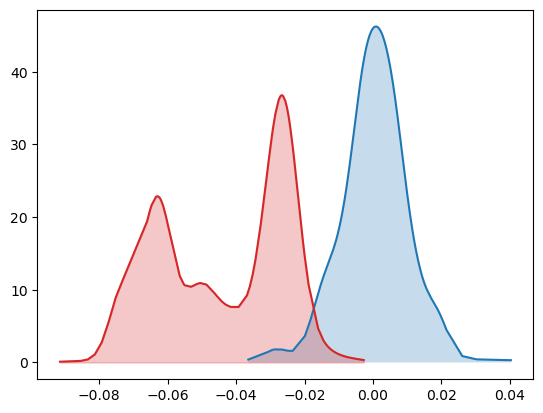

In [129]:
test_log_rets = log_returns_dict[llmtime_test_ticker].sort_values()
test_values = []
for window_size in llmtime_window_predictions["SP500"].keys():
    test_values_window = llmtime_window_predictions["SP500"][window_size]
    test_log_rets, test_values_window = test_log_rets.align(test_values_window, join="inner", axis=0)
    test_values.append(test_values_window.mode(axis=1).iloc[:, 0])
test_values = pd.concat(test_values, axis=0).sort_values()

kde_estimator = gaussian_kde(test_log_rets)
kde_pdf = kde_estimator.pdf(test_log_rets)
plt.plot(test_log_rets, kde_pdf)
plt.fill_between(test_log_rets, y1=0, y2=kde_pdf, alpha=0.25)

kde_estimator = gaussian_kde(test_values)
kde_pdf = kde_estimator.pdf(test_values)
while (kde_pdf[-1] > 1).any():
    test_values = pd.concat([test_values, pd.Series(np.linspace(test_values.iloc[-1], test_values.iloc[-1] * 0.2, num=20))], axis=0).reset_index(drop=True).sort_values()
    kde_estimator = gaussian_kde(test_values)
    kde_pdf = kde_estimator.pdf(test_values)
while (kde_pdf[0] > 4).any():
    test_values = pd.concat([test_values, pd.Series(np.linspace(test_values.iloc[0], test_values.iloc[0] * 1.25, num=10))], axis=0).reset_index(drop=True).sort_values()
    kde_estimator = gaussian_kde(test_values)
    kde_pdf = kde_estimator.pdf(test_values)
plt.plot(test_values, kde_pdf, color=plt.get_cmap("tab10")(3))
plt.fill_between(test_values, y1=0, y2=kde_pdf, alpha=0.25, color=plt.get_cmap("tab10")(3))
# plt.ylim([0, 50])
# sns.kdeplot(test_log_rets, fill=True, linewidth=2, color=plt.get_cmap("tab10")(0), label="Actual")
# sns.kdeplot(test_values, fill=True, linewidth=2, color=plt.get_cmap("tab10")(0), label="Actual")

#### LLM plots

In [88]:
for llmtime_test_window in tqdm(llmtime_window_predictions_distribution_plot.keys(), "Ptotting ES for LLM..."):
    fig, ax = plt.subplots(3, 3, figsize=(30, 18))
    for i, llmtime_test_ticker in enumerate(llmtime_window_predictions_distribution_plot[llmtime_test_window].keys()):
        test_values = llmtime_window_predictions_distribution_plot[llmtime_test_window][llmtime_test_ticker]
        test_log_rets = log_returns_dict[llmtime_test_ticker]
        test_log_rets, test_values = test_log_rets.align(test_values, join="inner", axis=0)
        formatted_asset_name = llmtime_test_ticker.upper()
        current_ax = ax[i // 3, i % 3]
        # If all values will be taken into account
        # test_values_list = []
        # for _, test_values_daily in test_values.iterrows():
        #     # test_values_window = llmtime_window_predictions["SP500"][window_size]
        #     # test_log_rets, test_values_window = test_log_rets.align(test_values_window, join="inner", axis=0)
        #     test_values_list.append(test_values_daily)
        # test_values = pd.concat(test_values_list, axis=0).reset_index(drop=True).sort_values()
        test_values = test_values.melt(var_name="Variable", value_name="Value")["Value"]
        # If only mode is taken into account
        # test_log_rets = test_log_rets.sort_values()
        # test_values = test_values_window.mode(axis=1).iloc[:, 0].sort_values()
        
        sns.kdeplot(test_log_rets, ax=current_ax, fill=True, linewidth=2, color=plt.get_cmap("tab10")(0), label="Actual")
        sns.kdeplot(test_values, ax=current_ax, fill=True, linewidth=2, color=plt.get_cmap("tab10")(3), label="LLM")

        current_ax.set_xlabel(fr"${formatted_asset_name}$", fontsize=30)
        current_ax.set_ylabel("")
        # current_ax.legend(loc="upper right")

    # plt.suptitle(f"Distribution plot for LLMTime window {llmtime_test_window}", fontsize=40)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.35)

    plt.savefig(distribution_plot_results_directory / f"ES_LLM_{llmtime_test_window}.png", transparent=True, bbox_inches="tight")
    plt.close(fig)

Ptotting ES for LLM...: 100%|██████████| 6/6 [01:35<00:00, 15.98s/it]


## Traffic light from <cite id="n9cnr"><a href="#zotero%7C12595123%2FFX5YUCYG">(Costanzino &#38; Curran, 2018)</a></cite>

### Short description

This test stems from <cite id="xurtj"><a href="#zotero%7C12595123%2FYJRN36EJ">(Costanzino &#38; Curran, 2015)</a></cite>. The spectral risk measure

$$
\large \frac{1}{\alpha} \int_0^{\alpha} \mathcal{1}_{r_t \le VaR_t(p)} \text{ } dp
$$
is replaced by

$$
\large TL^{ES} = \sum_{t=1}^T \left( 1 - \frac{F_L(r_t)}{\alpha} \right) \cdot I_t
$$

where 

- $r = (r)_t$ is the log return time series
- $I_t$ is the VaR exceedance indicator: $I_t = \mathcal{1}_{X_t < -VaR_{\alpha, t}}$.
- $VaR_t(p)$ is the Value-at-Risk for time $t$ and quantile level $p$
- $F_L$ is the assumed cumulative distribution of the losses $L$ ( -log returns).

### Choice of $F_L$

The presence of $F_L$ makes it rather problematic to test, however. If we assume a volatility estimator with known conditional distribution at time $t$ (which is the case for EWMA and GARCH), estimating the whole distribution is very tricky.

In fact, <cite id="yi1c4"><a href="#zotero%7C12595123%2F5ZQTSP9P">(Karim et al., 2023)</a></cite> have analitically computed $F_L$ for GARCH with normal residuals after $h$ time horizons and it is increasingly difficult, even with optimized code, even for small $h$. 

To add salt to injury, we could find no studies using this exact test aside from <cite id="unxac"><a href="#zotero%7C12595123%2FT2GHH5LV">(Alexander &#38; Dakos, 2023)</a></cite>, which use $F_t$ instead of $F_L$.

Using the empirical CDF of the log returns $F_{emp}$ implies a uniform distribution.

$$ \large F_{emp}(r_t) = \frac{1}{T} \sum_{t=0}^T \mathcal{1}_{r_t \le r_k}$$

### Test statistic

Under a sufficiently large sample, a normal approximation is possible:

$$
\large TL^{ES} \sim \mathcal{N}\left(\frac{1}{2} T \alpha, \alpha T \left(\frac{4 - 3 \alpha}{12} \right)\right)
$$

A more accurate approximation is possible by solving numerically for the CDF of $TL^{ES}$.

In our case, according to <cite id="n5bx9"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite>, we are in the clear because $T$ is larger than one financiar year in all cases. 

Because of how the test was designed, we can use the same traffic light rules as for VaR.

### Problem

#### Choice of $\alpha$
When looking carefully, there is a very important question: *which $\alpha$ is used for VaR and which for ES?*

Equation (7) uses the same significance level symbol for both $I_t$ and the severity weight factor. In section 4 it is also implied that VaR is computed at $\alpha = 2.5\%$.

Therefore, if this were true, we would need to comute the test using 2.5% VaR instead of 1%. You can perform this calculation by changing `alpha_VaR` at the beginning of this notebook, running only the `Read datasets` and `ES backtesting` sections.

Results do not vary that much, but it is important to establish what we use in the end.

#### Empirical CDF evaluation

For some reason, using scipy's implementatation for ECDF and evaluating on the same data (i.e. what we do in this test) computes $P(X \le x)$. This does not change results much. We use $\lt$ now.

#### Negative statistic
All methods seemingly pass this test. However, upon closer inspection of the statistics (look below), we see *negative values*, especially very large ones for LLM. Having negative values is a big issue, because **the test passes**.

Even though authors imagined that the statistic can only take positive values, it seems that in practice we can also have negative values. Regrettably, there is no practical experiment performed by the authors and we could not find this test used in other studies. 

Whenever we have an exceedance, we compute $\large 1 - \frac{F_L(r_t)}{\alpha}$. In the paper, it is mentioned that *in case* $r_t$ is "too negative", $F_L \approx 0$. However, this is not the case when **VaR is incorrectly specified**. We can have $F_L(r_t) \gt \alpha$, and thus overall a negative value for time $t$. If this happens "often enough", $TL^{ES}$ will be negative. In case of GPT 4, the LLM VaR is incorrectly specified, and thus we see large negative statistics.

In <cite id="n5bx9"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite>, for the general Coverage test we see that $H_0$ includes an additional assumption: a correctly specified VaR model. Although authors of this test do not specify their hypotheses explicitly, it is likely that it inherits this assumption.

Even with this in mind, we see that `ewma_dcs_normal` statistic is slightly negative, but this method is the only one which passes all VaR tests. This happens because, even though there are only a few exceedances, $F_L$ assigns a larger probability than necessary for only one of them, which cancels the others when summing. Example for `ewma_dcs_normal_80`, `cact` is presented in the 5 cells below the next one.

Therefore, $F_L$ also plays an important role. There is an implementation using Kernel Density Estimation (using empirical integration to find $P(X \lt x)$), and results in slightly different results, with more negatives. It can be toggled in the cell below, by commenting `compute_return_empirical_cdf` and decommenting `compute_return_kde_cdf`.

In [786]:
def compute_return_empirical_cdf(returns: np.ndarray):
    return (returns[:, None] < returns).sum(axis=0) / returns.shape[0]
    # return ecdf(returns).cdf.evaluate(returns)

def compute_return_kde_cdf(returns: np.ndarray):
    kde = gaussian_kde(returns)
    min_point = returns.min()
    i, num_tries = 0, 1_000
    while i < num_tries and kde.pdf(min_point) > 0.1:
        min_point -= 1e-3
        i += 1
    return np.array([kde.integrate_box_1d(low=min_point, high=ret) for ret in returns])

ES_traffic_light_backtest = {asset: {} for asset in llmtime_assets}
ES_traffic_light_statistic = {asset: {} for asset in llmtime_assets}
for estimator, asset_window_VaR_dict in tqdm(VaR_predictions.items(), desc="Traffic light ES test..."):
    for asset, window_VaR in asset_window_VaR_dict.items():
        window_ES_TL_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
            window_VaR.rename("VaR"), how="inner", left_index=True, right_index=True
        )

        # Compute empirical CDF
        window_ES_TL_test_data["prob"] = pd.Series(
            compute_return_empirical_cdf(window_ES_TL_test_data["returns"].to_numpy(dtype="float64")), 
            # compute_return_kde_cdf(window_ES_TL_test_data["returns"].to_numpy(dtype="float64")), 
            index=window_ES_TL_test_data.index
        )

        # Compute the test statistic for all $t$
        window_ES_TL_VaR_exceedances = window_ES_TL_test_data["returns"].lt(window_ES_TL_test_data["VaR"], axis=0).astype(int)
        window_ES_TL_ES_exceedances = (1 - window_ES_TL_test_data["prob"] / alpha_VaR) * window_ES_TL_VaR_exceedances
        
        estimator_ES_traffic_light_exceedences = window_ES_TL_ES_exceedances.sum()
        # if estimator_ES_traffic_light_exceedences > 0:
        N_ES_traffic_light = len(window_ES_TL_ES_exceedances)
        ES_TL_normal_approximation_mean =  0.5 * N_ES_traffic_light * alpha_VaR
        ES_TL_normal_approximation_variance = N_ES_traffic_light * alpha_VaR * (4 - 3 * alpha_VaR) / 12
        estimator_ES_traffic_light_statistic = norm.cdf((estimator_ES_traffic_light_exceedences - ES_TL_normal_approximation_mean) / np.sqrt(ES_TL_normal_approximation_variance))
        ES_traffic_light_backtest[asset][estimator] = estimator_ES_traffic_light_statistic
        ES_traffic_light_statistic[asset][estimator] = estimator_ES_traffic_light_exceedences
        # else:
            # In case VaR is not correctly specified, without this check we would have a large negative average exceedance (which doesn't make sense), and therefore the test would pass
            # ES_traffic_light_backtest[asset][estimator] = "INCORRECT"
    #     if asset == "cact":
    #         break
    # if estimator == "ewma_dcs_normal_80":
    #     break

Traffic light ES test...: 100%|██████████| 19/19 [00:00<00:00, 46.93it/s]


In [775]:
estimator_ES_traffic_light_exceedences

-4.818181818181817

In [776]:
test = (1 - window_ES_TL_test_data["prob"] / alpha_ES) * window_ES_TL_VaR_exceedances

In [777]:
test_filtered_ES = window_ES_TL_test_data["prob"][window_ES_TL_VaR_exceedances == 1][window_ES_TL_test_data["prob"][window_ES_TL_VaR_exceedances == 1] > alpha_VaR]

In [778]:
pd.concat([window_ES_TL_test_data.loc[test_filtered_ES.index], test[test_filtered_ES.index]], axis=1)

,returns,VaR,prob,0
2022-12-15,-0.029794,-0.024658,0.010909,0.563636
2023-03-13,-0.029480,-0.023688,0.012727,0.490909
2024-01-03,-0.015954,-0.014984,0.063636,-1.545455


<Axes: title={'center': 'Individual Traffic light scores for $t$'}, ylabel='Frequency'>

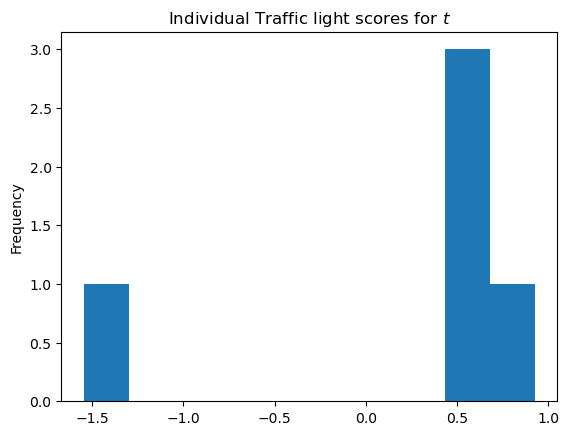

In [781]:
test[test != 0].plot.hist(title=r"Individual Traffic light scores for $t$")

In [787]:
pd.DataFrame(ES_traffic_light_backtest)

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
llmtime_120,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
llmtime_150,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
llmtime_30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
llmtime_45,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
llmtime_60,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
llmtime_90,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
garch_lpa,2.205246e-02,2.209292e-01,1.212226e-02,0.002336,2.456365e-10,3.358695e-06,1.379408e-01,0.469072,6.228040e-01
ewma_normal_80,1.370369e-01,2.830648e-25,8.372004e-41,0.005162,1.736602e-24,5.258393e-15,3.283015e-21,0.000003,5.708748e-05
ewma_normal_120,7.215446e-03,9.580877e-21,8.372004e-41,0.136404,2.323414e-21,6.802835e-10,2.527785e-11,0.000020,1.618289e-03
ewma_dcs_normal_80,3.491818e-03,4.471647e-06,1.594327e-01,0.000019,1.040112e-01,2.031973e-04,3.989464e-03,0.014139,1.008412e-08


In [788]:
pd.DataFrame(ES_traffic_light_statistic)

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
llmtime_120,-196.221311,-332.921811,-595.107050,-259.593625,-122.826446,-355.581967,-258.793587,-172.725490,-238.632735
llmtime_150,-166.655022,-266.938596,-449.119565,-183.186441,-193.907489,-306.986900,-181.138593,-224.541667,-246.535032
llmtime_30,-511.055363,-270.375000,-783.682243,-371.155405,-498.470383,-508.685121,-380.541596,-410.500000,-471.857868
llmtime_45,-316.344583,-286.828877,-335.033294,-219.311958,-299.576029,-311.877442,-251.986063,-185.376068,-278.784722
llmtime_60,-246.321168,-260.648352,-347.380145,-224.039146,-314.845588,-234.642336,-253.601073,-241.017544,-214.297683
llmtime_90,-260.826255,-335.790698,-492.567839,-238.203008,-222.782101,-324.884170,-296.374291,-138.000000,-167.909605
garch_lpa,-0.013183,1.627599,0.597765,-1.073394,-5.586011,-3.312618,1.250923,2.660036,3.139706
ewma_normal_80,1.227188,-11.056075,-18.452514,-0.707804,-10.822430,-7.621974,-9.890511,-3.343470,-2.454545
ewma_normal_120,-0.651911,-9.383838,-18.452514,1.129159,-9.575758,-5.285714,-5.976378,-2.789981,-1.274510
ewma_dcs_normal_80,-0.910615,-3.233645,2.759777,-2.803993,1.000000,-2.027933,-0.832117,-0.187835,-4.818182


In [523]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_traffic_light_df = pd.DataFrame.from_dict(ES_traffic_light_backtest)

# Convert LLMTime estimator names
ES_traffic_light_df = ES_traffic_light_df.set_axis([estimator if isinstance(estimator, str) else f"llmtime_{estimator}" for estimator in ES_traffic_light_df.index], axis=0)

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_traffic_light_df.index = (ES_traffic_light_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_traffic_light_df.columns = ES_traffic_light_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_traffic_light_df.index = ES_traffic_light_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_traffic_light_df = ES_traffic_light_df[asset_table_ordering]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(value):
    if isinstance(value, float):
        if value < 0.95:
            return '\\cellcolor{green} ' + f'{value:.3f}'
        if 0.95 <= value < 0.99:
            return '\\cellcolor{yellow} ' + f'{value:.3f}'
        if value >= 0.99:
            return '\\cellcolor{red} ' + f'{value:.3f}'
    else:
        return value

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_traffic_light_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_traffic_light_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in ES_traffic_light_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([format_value(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_traffic_light_df.to_csv(results_directory / "ES_traffic_light.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_traffic_light.tex", "w") as f:
    f.write(latex_code)

## Spectral risk measure test <cite id="dxn0x"><a href="#zotero%7C12595123%2FYJRN36EJ">(Costanzino &#38; Curran, 2015)</a></cite>

### Description

A generalization of <cite id="c085x"><a href="#zotero%7C12595123%2FFX5YUCYG">(Costanzino &#38; Curran, 2018)</a></cite> for any spectral risk measure.

A continuous version of testing multiple VaR quantiles.

### Test statistic

The test statistic for ES is defined as:

$$
\large \frac{1}{\alpha} \int_0^{\alpha} \mathcal{1}_{r_t \le VaR_t(p)} \text{ } dp
$$

Using an observation of <cite id="n43jg"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite>,

$$
\large Q_{c}^T = \frac{1}{\alpha} \int_0^{\alpha} \mathcal{1}_{r_t \le VaR_t(p)} \text{ } dp = \frac{1}{T \alpha} \sum_{t=1}^T I_t [\alpha - F_t(r_t)]
$$

which, critically, only depends on the conditional distribution. For LLM, we use the empirical daily CDF. 

For EWMA and GARCH, we sample from the daily conditional distributions:
-  Normally distributed residuals: $\large \hat{r}_t = \sigma_t \epsilon_t$, where $\large \epsilon_t \sim \mathcal{N}(0, 1)$
-  Student distributed residuals: $\large \hat{r}_t = \sigma_t \epsilon_t$, where $\large \epsilon_t \sim \mathcal{t}(0, 1, \nu)$ (in accordance to [this](https://quant.stackexchange.com/questions/36387/var-student-t-garch) link)

Asymptotics are very slightly changed compared to the traffic light test:

$$
\large Q_c^T \sim \mathcal{N}\left(\frac{\alpha}{2}, \frac{\alpha}{T} \left( \frac{4 - 3 \alpha}{12} \right)\right)
$$

There is no traffic light interpretation, therefore we report p-values.

According to <cite id="6tb4k"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite>, we reject the test when $\Phi(Q_c^T) \ge 1 - \alpha$, therefore we report $1 -\Phi(Q_c^T)$ for consistency with other tests.

### Problems

#### Choice of $\alpha$

Although not directly specified anywhere, $\alpha$ should be the one for VaR, given this is a generalization of the Traffic light test. Probably a way to see this is looking at the integral form of the statistic.

In this case, the test is very sensitive and we see more failures with different choices.

There are two p-value tables for comparison below. First is with 1% VaR, the next with 2.5%.

#### Continuity

<cite id="6tb4k"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite> assume continuous and strictly increasing $F_t$, which is not the case for ECDF (what we use for LLM).

#### Negative values

The same issue as above applies here when we compute $\large \alpha - F_t(r_t)$. It is expected that this term is positive (see under equation (3.2) in the original paper), however for incorrectly specified VaR we can obtain negative values.

In [731]:
def compute_empirical_cdf_probability(row: pd.Series):
    log_return_llm_values = np.sort(row.loc[[text for text in row.index if "distribution_" in text]].unique())
    actual_return = row.loc["returns"]
    empirical_cdf_probability = (log_return_llm_values < actual_return).sum() / len(log_return_llm_values)
    return empirical_cdf_probability

ES_spectral_backtest = {asset: {} for asset in llmtime_assets}
ES_spectral_statistics = {asset: {} for asset in llmtime_assets}
llmtime_return_empirical_cdf_probabilities = {asset: {} for asset in llmtime_assets}
for llmtime_test_ticker in tqdm(llmtime_window_predictions.keys(), "Spectral measure ES for LLM..."):
    for llmtime_test_window in llmtime_window_predictions[llmtime_test_ticker].keys():
        llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
        llmtime_test_data_VaR = estimate_llm_VaR_ES({"test": llmtime_test_data})["test"]["VaR"]
        llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
            llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}), 
            how="inner", left_index=True, right_index=True
        ).merge(llmtime_test_data_VaR.rename("VaR"), how="inner", left_index=True, right_index=True)

        # Empirical CDF for LLM
        window_SR_TL_test_data_probabilities = llmtime_test_data.apply(compute_empirical_cdf_probability, axis=1)

        # Compute the test statistic for all $t$
        window_ES_SR_VaR_exceedances = llmtime_test_data["returns"].lt(llmtime_test_data["VaR"], axis=0).astype(int)
        window_ES_SR_ES_terms = window_ES_SR_VaR_exceedances * (alpha_VaR - window_SR_TL_test_data_probabilities)

        llmtime_ES_SR_statistic = window_ES_SR_ES_terms.sum() / (len(window_ES_SR_VaR_exceedances) * alpha_VaR)
        # if llmtime_ES_SR_statistic >= 0:
        N_ES_SR = len(window_ES_SR_VaR_exceedances)
        ES_SR_normal_approximation_mean =  0.5 * alpha_VaR
        ES_SR_normal_approximation_variance = alpha_VaR / N_ES_SR * (4 - 3 * alpha_VaR) / 12
        llmtime_ES_traffic_light_statistic = 1 - norm.cdf(
            (llmtime_ES_SR_statistic - ES_SR_normal_approximation_mean) / np.sqrt(ES_SR_normal_approximation_variance)
        )
        
        ES_spectral_backtest[llmtime_test_ticker][llmtime_test_window] = llmtime_ES_traffic_light_statistic
        # else:
        #     ES_spectral_backtest[llmtime_test_ticker][llmtime_test_window] = "INCORRECT"
        llmtime_return_empirical_cdf_probabilities[llmtime_test_ticker][llmtime_test_window] = window_SR_TL_test_data_probabilities
        ES_spectral_statistics[llmtime_test_ticker][llmtime_test_window] = llmtime_ES_SR_statistic
    #     if llmtime_test_window == 45:
    #         break
    # if llmtime_test_ticker == "CRIX":
    #     break

Spectral measure ES for LLM...: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


In [732]:
def compute_residual_probability(row: pd.Series, estimator_distribution: str):
    actual_return = row.loc["returns"]
    volatility = row.loc["volatility"]
     # Only works for the normal distribution, we use it only for GARCH LPA
    if "rescale_mean" in row.index:
        rescale_mean = row.loc["rescale_mean"]
    else:
        rescale_mean = 0
    if "rescale_std" in row.index:
        rescale_std = row.loc["rescale_std"]
    else:
        rescale_std = 1
    if estimator_distribution == "normal":
        # LPA: scale returns before computing CDF
        rescaled_return = (actual_return  - rescale_mean) / rescale_std
        cdf_probability = norm.cdf(rescaled_return, loc=0, scale=volatility)
    elif estimator_distribution == "t":
        cdf_probability = t.cdf(actual_return, loc=0, scale=volatility, df=t_nu)
    else:
        raise NotImplementedError(f"Unknown distribution type {estimator_distribution}.")
    
    return cdf_probability

residual_distribution_cdf_probabilities = {asset: {} for asset in llmtime_assets}
for estimator, asset_window_volatilities_dict in tqdm(volatility_predictions.items(), desc="Traffic light ES classical methods..."):
    for asset, window_volatility in asset_window_volatilities_dict.items():
        window_VaR_test_data = VaR_predictions[estimator][asset]
        
        window_volatility_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
            window_VaR_test_data.rename("VaR"), how="inner", left_index=True, right_index=True
        ).merge(
            window_volatility.rename("volatility"), how="inner", left_index=True, right_index=True
        )

        # Rescale if using GARCH LPA
        if estimator == "garch_lpa":
            window_volatility_test_data = window_volatility_test_data.merge(garch_lpa_rescaling_dict[asset], how="inner", left_index=True, right_index=True)

        volatility_distribution_estimator_name = "_".join(estimator.split("_")[:-1]) if re.match(r".*?_\d+", estimator) else estimator
        window_volatility_residual_distribution = volatility_distributions[volatility_distribution_estimator_name]
        window_volatility_test_SR_probabilities = window_volatility_test_data.apply(compute_residual_probability, args=(window_volatility_residual_distribution,), axis=1)

        # Compute the test statistic for all $t$
        window_volatility_SR_VaR_exceedances = window_volatility_test_data["returns"].lt(window_volatility_test_data["VaR"], axis=0).astype(int)
        window_volatility_SR_ES_terms = window_volatility_SR_VaR_exceedances * (alpha_VaR - window_volatility_test_SR_probabilities)
        
        window_volatility_SR_ES_statistic = window_volatility_SR_ES_terms.sum() / (len(window_volatility_test_data) * alpha_VaR)
        # if window_volatility_SR_ES_statistic >= 0:
        N_ES_SR = len(window_volatility_test_data)
        ES_SR_normal_approximation_mean =  0.5 * alpha_VaR
        ES_SR_normal_approximation_variance = alpha_VaR / N_ES_SR * (4 - 3 * alpha_VaR) / 12
        estimator_ES_traffic_light_statistic = 1 - norm.cdf((window_volatility_SR_ES_statistic - ES_SR_normal_approximation_mean) / np.sqrt(ES_SR_normal_approximation_variance))
        
        ES_spectral_backtest[asset][estimator] = estimator_ES_traffic_light_statistic
        # else:
        #     ES_spectral_backtest[asset][estimator] = "INCORRECT"
        residual_distribution_cdf_probabilities[asset][estimator] = window_volatility_test_SR_probabilities
        ES_spectral_statistics[asset][estimator] = window_volatility_SR_ES_statistic
    #     if asset == "cbu":
    #         break
    # if estimator == "ewma_dcs_t_80":
    #     break

Traffic light ES classical methods...: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


In [733]:
pd.DataFrame(ES_spectral_backtest)

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
120,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
150,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
30,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
45,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
60,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
90,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
garch_lpa,0.987329,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
ewma_normal_80,0.000603,1.955652e-10,0.000000e+00,4.023088e-08,6.222781e-03,2.210901e-10,3.485857e-08,2.523818e-06,0.000002
ewma_normal_120,0.000009,1.708505e-07,0.000000e+00,3.146445e-04,7.892912e-06,1.879302e-07,1.267349e-05,1.854941e-05,0.029637
ewma_dcs_normal_80,0.406588,6.940513e-01,1.877428e-01,4.817781e-02,8.959888e-01,4.065883e-01,4.234410e-01,5.246278e-02,0.047658


In [723]:
pd.DataFrame(ES_spectral_backtest)

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
120,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
150,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
30,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
45,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
60,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
90,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
garch_lpa,1.000000,1.000000e+00,9.999985e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.984643,1.000000e+00
ewma_normal_80,0.000253,1.231237e-13,0.000000e+00,8.238441e-08,3.176490e-08,2.262325e-09,8.139146e-07,0.000001,9.014321e-07
ewma_normal_120,0.000380,1.887379e-15,0.000000e+00,9.801891e-05,5.377883e-07,4.370960e-08,1.097390e-05,0.000002,5.889983e-04
ewma_dcs_normal_80,0.633078,2.651613e-01,3.819591e-01,3.000999e-01,7.901101e-01,5.834230e-02,4.717545e-01,0.317901,8.116895e-01


In [713]:
pd.DataFrame(ES_spectral_statistics)

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
120,-0.149897,-0.273007,-0.361499,-0.208167,-0.065171,-0.393233,-0.199423,-0.174974,-0.270206
150,-0.178765,-0.321820,-0.262694,-0.136715,-0.236172,-0.374285,-0.195896,-0.205937,-0.305259
30,-0.287715,-0.144211,-0.285399,-0.042077,-0.140595,-0.185315,-0.130299,-0.283347,-0.261789
45,-0.242907,-0.173652,-0.090784,-0.047214,-0.190080,-0.143527,-0.100464,-0.083249,-0.122637
60,-0.178433,-0.245624,-0.195092,-0.183378,-0.211227,-0.090933,-0.174088,-0.210823,-0.145028
90,-0.228063,-0.266238,-0.271498,-0.172255,-0.144474,-0.314819,-0.174935,-0.184619,-0.177588
garch_lpa,-0.000587,-0.157707,-0.016297,-0.076567,-0.034923,-0.190409,-0.085478,-0.020917,-0.122284
ewma_normal_80,0.013035,0.020561,0.025698,0.018149,0.011215,0.020484,0.018248,0.016100,0.016364
ewma_normal_120,0.016097,0.018182,0.025698,0.013699,0.016162,0.018109,0.015748,0.015414,0.009804
ewma_dcs_normal_80,0.005587,0.003738,0.006704,0.009074,0.001869,0.005587,0.005474,0.008945,0.009091


In [193]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_spectral_df = pd.DataFrame.from_dict(ES_spectral_backtest)

# Convert LLMTime estimator names
ES_spectral_df = ES_spectral_df.set_axis([estimator if isinstance(estimator, str) else f"llmtime_{estimator}" for estimator in ES_spectral_df.index], axis=0)

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_spectral_df.index = (ES_spectral_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_spectral_df.columns = ES_spectral_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_spectral_df.index = ES_spectral_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_spectral_df = ES_spectral_df[asset_table_ordering]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val > 0.05:
            if val > 0.5:
                color = "green!70!white"  # Darker green for higher values
            else:
                color = "green!30!white"  # Lighter green for values near 0.05
        else:
            if val < 0.01:
                color = "red!70!white"  # Darker red for lower values
            else:
                color = "red!30!white"  # Lighter red for values near 0.05
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_spectral_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_spectral_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in ES_spectral_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([format_value(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_spectral_df.to_csv(results_directory / "ES_spectral.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_spectral.tex", "w") as f:
    f.write(latex_code)

## Exceedance residual (ER) <cite id="6p6ed"><a href="#zotero%7C12595123%2F7G6HYGQV">(McNeil &#38; Frey, 2000)</a></cite>

#### Description

A test which employs the ES estimation directly. 

Unlike our other tests, this one is employed in a few works:

- <cite id="2dmtw"><a href="#zotero%7C12595123%2FT2GHH5LV">(Alexander &#38; Dakos, 2023)</a></cite>
- <cite id="hdorj"><a href="#zotero%7C12595123%2F66IRPRTK">(Benito Muela et al., 2023)</a></cite> calls this test "the most successful in the literature"
- <cite id="r4ij4"><a href="#zotero%7C12595123%2FSYW4CGYB">(Bayer &#38; Dimitriadis, 2022)</a></cite> uses it a a benchmark for their novel methodology
- <cite id="oolij"><a href="#zotero%7C12595123%2FUDNZXFSP">(Lazar &#38; Zhang, 2019)</a></cite> considers it in the same category as $Z_2$ from <cite id="cvxka"><a href="#zotero%7C12595123%2FBTJLF7TJ">(Acerbi &#38; Szekely, 2014)</a></cite>

#### Test statistic

$$
 \large ER = \frac{\sum_{t=1}^T (-r_t -ES_{\alpha, t}) \cdot I_t}{\sum_{t=1}^T I_t} = \frac{\sum_{t=1}^T \epsilon_t}{\sum_{t=1}^T I_t}
$$

The sign of $r_t$ differs between between authors. We choose <cite id="qw07s"><a href="#zotero%7C12595123%2FT2GHH5LV">(Alexander &#38; Dakos, 2023)</a></cite> suggestions (although all other studies used a different approach) because we usually have $\widehat{ES}_{\alpha, t} \lt |r_t|$ and, in this case, the quantity is well defined.

There are 2 major alternatives:
- A "raw" version, which tests $\epsilon_t$ directly
- A "standardized" version, which tests $\large \frac{\epsilon_t}{\sigma_t}$

In accordance with <cite id="5tkch"><a href="#zotero%7C12595123%2FSYW4CGYB">(Bayer &#38; Dimitriadis, 2022)</a></cite>, we choose the former.

#### Estimation

The test statistic does not follow a standard distribution and is obtained via bootstrapping. 

We bootstrap to find the distribution of $E[\epsilon]$, and then test using hypotheses:

$$
\large \begin{split}
H_0: E[\epsilon] = 0 \\
H_1: E[\epsilon] \gt 0
\end{split}
$$

More specifically:
- Sample $D$ blocks with replacement from $\epsilon$ (we choose block size $T$)
- For each block $\epsilon_d$, compute $E[\epsilon_d]$
- Approximate a distribution for $E[\epsilon]$, then compute our "p-value" as 

$$\large P(E[\epsilon] \le ER) \sim \frac{1}{D} \sum_{d=1}^D 1_{E[\epsilon_d] \le ER}$$

*<cite id="29nng"><a href="#zotero%7C12595123%2FEKNNRH67">(Efron &#38; Tibshirani, 1994)</a></cite> states that we should not interpret the statistic as a p-value.*

This test is not defined for no exceedances.

#### Why everything passes?

We looked for mistakes in the test and tried a few additional options.

- In the bootstrapping phase, insteda of $E[\epsilon_d]$, we tried
$$
\large \frac{\sum_{i=1}^T \epsilon_{d, i}}{\sum_{t=1}^T I_t}
$$
in the hopes that the test statistic and the bootstrapped distribution are using the same computation (code is commented below).
However, results are not better.

- Inspired by the Supplementary Material of <cite id="i402a"><a href="#zotero%7C12595123%2FSYW4CGYB">(Bayer &#38; Dimitriadis, 2022)</a></cite>, we went to <cite id="patwc"><a href="#zotero%7C12595123%2FEKNNRH67">(Efron &#38; Tibshirani, 1994)</a></cite>, p. 224, however the two means test presented there does not fit our scenario. We also tried to integrate the next section, `One-sample problem`, however the main question was if we could afford a $t$ test in this scenario. Also, the size of blocks $\overline{\mathcal{z}}^*$. In the end, we did not implement this experiment.

At the moment, this test is passed by almost all estimator-asset configurations. The only one where it doesn't, `ewma_dcs_t_80` with asset `djci`, has $|r_t| \lt \widehat{ES}_{\alpha, t}$ and $r_t \lt 0$, which leads to a negative $\epsilon_t$ (more specifically, $\epsilon_t = -(-0.055459) -0.056609 \lt 0$). This happens only for one VaR exceedance, and it is the only one for the aforementioned configuration. The problem is that all bootstrap samples are almost guaranteed to have *higher* statistics, given that we have only one breanch and we compute the "p-value" with the hope of higher statistics (this comes down to the definition of $\epsilon_t$). 

Long story short, *this test penalizes ES estimation over log return extremely harsh*.

In [74]:
ES_ER_backtest = {asset: {} for asset in llmtime_assets}
ES_ER_statistics = {asset: {} for asset in llmtime_assets}
ER_backtest_bootstrapping_replications = 1_000

for estimator, asset_window_VaR_dict in tqdm(VaR_predictions.items(), desc="ER ES test..."):
    for asset, window_VaR in asset_window_VaR_dict.items():
        window_VaR_test_data = VaR_predictions[estimator][asset]
        window_ES_test_data = ES_predictions[estimator][asset]
        window_ER_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
            window_VaR_test_data.rename("VaR"), how="inner", left_index=True, right_index=True
        ).merge(
            window_ES_test_data.rename("ES"), how="inner", left_index=True, right_index=True
        )

        # Compute the test statistic for all $t$
        window_ER_VaR_exceedances = window_ER_test_data["returns"].lt(window_ER_test_data["VaR"], axis=0).astype(int)
        window_ER_test_data["epsilon"] = (window_ER_test_data["returns"] + window_ER_test_data["ES"]) * window_ER_VaR_exceedances

        # Estimate the mean distribution of epsilon with bootstrapping
        # Sample exactly $T$ samples every time 
        window_ER_VaR_exceedances_numpy = window_ER_VaR_exceedances.values.astype(bool)
        epsilon_blocks = np.random.default_rng().choice(
            window_ER_test_data["epsilon"].to_numpy(), size=(len(window_ER_test_data), ER_backtest_bootstrapping_replications), replace=True
        )
        epsilon_block_statistics = np.apply_along_axis(
            # Mean computed the same way as the statistic; similar results
            lambda sample: sample[window_ER_VaR_exceedances_numpy].sum() / window_ER_VaR_exceedances_numpy.sum() if window_ER_VaR_exceedances_numpy.sum() > 0 else np.inf, 
            # lambda sample: sample.mean(), 
            0,  
            epsilon_blocks
        )

        # Compute the test statistic
        # The test is not defined for 0 exceedances, for the moment will report separately
        VaR_exceedances = window_ER_VaR_exceedances.sum()
        if VaR_exceedances > 0 and (~np.isinf(epsilon_block_statistics)).sum() > 0:
            ER_test_statistic = window_ER_test_data["epsilon"].sum() / VaR_exceedances
            epsilon_block_statistics = epsilon_block_statistics[~np.isinf(epsilon_block_statistics)]
            # According to the paper, perform a one-sided test with $\text{H_1: }E[\epsilon] \gt 0$
            # The p-value is thus $P(\epsilon \le b)$, where $b$ is the test statistic, computed using the empirical CDF
            ER_test_p_value = (ER_test_statistic > epsilon_block_statistics).sum() / epsilon_block_statistics.shape[0]
            ES_ER_statistics[asset][estimator] = ER_test_statistic
        else:
            ER_test_p_value = "NF"
            ES_ER_statistics[asset][estimator] = "NF"
        ES_ER_backtest[asset][estimator] = ER_test_p_value


ER ES test...: 100%|██████████| 19/19 [00:01<00:00, 10.16it/s]


In [75]:
pd.DataFrame.from_dict(ES_ER_statistics)

,djci,cact,stoxx,gdaxi,SPGTCLTR,ftse,CRIX,cbu,SP500
llmtime_45,-0.068731,-0.060672,-0.051938,-0.062224,-0.082095,-0.059262,-0.222827,-0.025559,NF
llmtime_120,NF,NF,NF,NF,NF,-0.069665,-0.355991,NF,NF
llmtime_30,-0.070361,-0.060539,-0.047946,-0.057444,-0.081659,-0.041773,-0.174093,-0.027795,-0.045011
llmtime_60,-0.091906,-0.058304,NF,NF,-0.083151,-0.061458,-0.245319,-0.025557,NF
llmtime_90,NF,NF,NF,NF,NF,-0.054578,-0.351992,NF,NF
llmtime_150,NF,NF,NF,NF,NF,-0.072308,NF,NF,NF
garch_lpa,-0.067654,-0.064799,-0.050456,-0.0622,-0.081377,-0.050591,-0.19397,-0.028599,-0.058703
ewma_normal_80,-0.058512,-0.05921,-0.051126,-0.056793,-0.076923,-0.044792,-0.157947,-0.02671,-0.054686
ewma_normal_120,-0.055448,-0.047135,-0.045205,-0.049675,-0.075543,-0.040183,-0.157947,-0.026162,-0.057822
ewma_dcs_normal_80,-0.065135,-0.051624,-0.049039,-0.055466,-0.075133,-0.044096,-0.212648,-0.028782,-0.086998


In [201]:
import pandas as pd


ES_ER_df = pd.DataFrame.from_dict(ES_ER_backtest)

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_ER_df.index = (ES_ER_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_ER_df.columns = ES_ER_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_ER_df.index = ES_ER_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_ER_df = ES_ER_df[asset_table_ordering]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val > 0.05:
            if val > 0.5:
                color = "green!70!white"  # Darker green for higher values
            else:
                color = "green!30!white"  # Lighter green for values near 0.05
        else:
            if val < 0.01:
                color = "red!70!white"  # Darker red for lower values
            else:
                color = "red!30!white"  # Lighter red for values near 0.05
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_ER_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_ER_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in ES_ER_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([format_value(val) for val in row]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_ER_df.to_csv(results_directory / "ES_ER.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_ER.tex", "w") as f:
    f.write(latex_code)

## Tests from <cite id="fbz75"><a href="#zotero%7C12595123%2FBTJLF7TJ">(Acerbi &#38; Szekely, 2014)</a></cite>

A set of 3 non-parametric tests with a widespread literature adoption. In particular, we found them to be used in:
- <cite id="oolij"><a href="#zotero%7C12595123%2FUDNZXFSP">(Lazar &#38; Zhang, 2019)</a></cite> - $Z_2$ plays an important role in testing their bias correction framework
- <cite id="6tb4k"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite> - empirical performance rundown for all three tests

Significance computations require sampling from assumed model distributions at each point $t$ and simulating a distribution of statistics.

- For EWMA and GARCH, we simulate the same as for the spectral risk test
- For LLM, we sample from a Gaussian Kernel Density Estimation of the dataset
  
where $p \sim Uniform(0,1)$, $t_{emp}, \varphi_{emp}$ represent the empirical estimates of the gaussian and Student densities respectively.
 
We sample $K$ times for each $t$, creating $K$ alternative log return time series, which are then used for computing the respective score's statistic. Similarly to <cite id="ykajk"><a href="#zotero%7C12595123%2FSEBZ3T4X">(Clift et al., 2016)</a></cite>, we take $K = 20,000$ simulations.

We then compute the test statistic for each simulation and build a distribution $(D)_k$, $k \in \{1, \dots, K\}$.

For a given significance level $\alpha$, we reject the test if

$$
\large \varphi_{Z} = \frac{1}{K} \sum_{k=1}^K \mathcal{1}_{D_k \le Z_{obs}} \le \alpha
$$

where $Z_{obs}$ is the observed statistic.

In [184]:
# Parameters for all tests

# Number of simulations for computing the test statistic
acerbi_backtesting_test_statistic_simulations = 20_000
# Number of parallel cores to use when estimating the statistic
# A larger value will speed up computations
# If "auto", will default to the total number of cores on the machine
acerbi_backtesting_test_statistic_n_jobs = 32 #"auto"

In [185]:
# General purpose routines

# Progress bar for parallel execution
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

def count_estimations(predictions_dict: dict[str, dict[int, pd.DataFrame]]):
    return sum({key: len(inner_dict) for key, inner_dict in predictions_dict.items()}.values())

# Perform simulation for all tests
def acerbi_szekely_simulation(
    simulator: Callable[[pd.DataFrame, int, Any], pd.DataFrame], 
    statistic_calculator: Callable[[pd.DataFrame], pd.Series], 
    data: pd.DataFrame, n_simulations: int, simulator_params: tuple[Any], 
    asset: str, statistic_calculator_params: tuple[Any] = (), add_all_columns_to_simulation: bool = False
):
    observed_statistic = statistic_calculator(data, *statistic_calculator_params).loc["returns"]

    if pd.notna(observed_statistic):
        simulated_returns = simulator(data, n_simulations, *simulator_params)
        if add_all_columns_to_simulation:
            simulated_data = pd.concat([simulated_returns, data[[col for col in data.columns if "return" not in col]]], axis=1)
        else:
            simulated_data = pd.concat([simulated_returns, data[["VaR", "ES"]]], axis=1)
        simulated_statistics = statistic_calculator(simulated_data, *statistic_calculator_params)
        if simulated_statistics.isna().sum() >= 0.25 * n_simulations:
            print(f"{simulated_statistics.isna().sum() / n_simulations:.2%} simulations removed because of no exceedance. Asset {asset}.")
            simulated_statistics = simulated_statistics.dropna()
        if simulated_statistics.shape[0] > 0:
            simulation_breaches = (simulated_statistics < observed_statistic).astype(int)
            return simulation_breaches.mean()
        else:
            return "NF"
    else:
        return "NF"

def acerbi_szekely_n_jobs():
    return cpu_count() - 1 if acerbi_backtesting_test_statistic_n_jobs == "auto" else min(acerbi_backtesting_test_statistic_n_jobs, cpu_count() - 1)

# Simulator for EWMA and GARCH-based methods - assumes $r_t = \sigma_t \epsilon_t$ for normal and student residuals
def volatility_based_simulator(volatilities: pd.DataFrame, n_simulations: int, distribution: str):
    samples = {}

    for index, daily_volatility_data in volatilities.iterrows():
        samples[index] = sample_from_known_distribution(daily_volatility_data, n_simulations=n_simulations, estimator_distribution=distribution)

    return pd.DataFrame.from_dict(samples, orient="index", columns=[f"returns_{i}" for i in range(n_simulations)]).sort_index()

def sample_from_known_distribution(row: pd.Series, n_simulations: int, estimator_distribution: str):
    # We store the variance, not volatility, a notation issue
    std_deviation = np.sqrt(row.loc["volatility"])
     # Only works for the normal distribution, we use it only for GARCH LPA
    if "rescale_mean" in row.index:
        rescale_mean = row.loc["rescale_mean"]
    else:
        rescale_mean = 0
    if "rescale_std" in row.index:
        rescale_std = row.loc["rescale_std"]
    else:
        rescale_std = 1
    if estimator_distribution == "normal":
        # $r_t = \sigma_t \epsilon_t$, where $\epsilon_t \sim \cal{N}(0, 1)$
        samples = std_deviation * norm(loc=0, scale=1).rvs(size=n_simulations)
        # LPA: rescale observations after sampling
        rescaled_samples = (samples * rescale_std) + rescale_mean
    elif estimator_distribution == "t":
        # rescaled_samples = t(loc=0, scale=std_deviation, df=t_nu).rvs(size=n_simulations)
        # $r_t = \sigma_t \epsilon_t$, where $\epsilon_t \sim  t(0, 1, \nu)$
        rescaled_samples = std_deviation * t(loc=0, scale=1, df=t_nu).rvs(size=n_simulations) #* np.sqrt(t_nu / (t_nu - 2))
    else:
        raise NotImplementedError(f"Unknown distribution type {estimator_distribution}.")
    
    return rescaled_samples

# Simulator for LLM - we sample from empirical CDF using linear interpolation
# Does not work in practice because it resembles a uniform distribution
def empirical_interpolation_based_simulator(daily_distributions: pd.DataFrame, n_simulations: int, columns_to_keep_pattern: str):
    def linear_interpolation_from_data(distribution_values: pd.Series):
        sorted_distribution = np.sort(distribution_values.unique())
        new_random_points = np.random.uniform(0, 1, size=n_simulations)
        interpolated_points = np.interp(new_random_points, np.linspace(0, 1, num=len(sorted_distribution)), sorted_distribution)
        return interpolated_points

    interpolated_points = daily_distributions[[col for col in daily_distributions if columns_to_keep_pattern in col]].apply(linear_interpolation_from_data, axis=1)
    interpolated_points_frame = pd.DataFrame(interpolated_points.to_list(), index=interpolated_points.index, columns=[f"returns_{i}" for i in range(n_simulations)])
    return interpolated_points_frame

# Simulator for LLM - we sample from the KDE approximation of our daily distributions
# Upon visual inspection, the tophat kernel proved the a better choice than gaussian (no other options for sampling)

def empirical_kde_based_simulator(daily_distributions: pd.DataFrame, n_simulations: int, columns_to_keep_pattern: str, bandwidth: float):
    def kernel_denstity_estimation_based_sampling(data: pd.Series):
        kde_test = gaussian_kde(data.to_numpy())
        kde_test_samples = kde_test.resample(size=n_simulations).squeeze(0)
        
        return kde_test_samples

    kde_sampled_points = daily_distributions[[col for col in daily_distributions if columns_to_keep_pattern in col]].apply(kernel_denstity_estimation_based_sampling, axis=1)
    # print(kde_sampled_points.shape)
    kde_sampled_points_frame = pd.DataFrame(kde_sampled_points.to_list(), index=kde_sampled_points.index, columns=[f"returns_{i}" for i in range(n_simulations)])

    return kde_sampled_points_frame

# Estimates directly from the actual log returns assuming a normal or student distribution
def empirical_log_return_estimator(daily_distributions: pd.DataFrame, n_simulations: int, distribution: str = "normal"):
    rng = np.random.default_rng()
    if distribution == "normal":
        approximation = norm(*norm.fit(daily_distributions["returns"]))
        samples = approximation.rvs(size=(daily_distributions.shape[0], n_simulations))
    elif distribution == "t":
        approximation = t(*t.fit(daily_distributions["returns"]))
        samples = approximation.rvs(size=(daily_distributions.shape[0], n_simulations))
    elif distribution == "combined":
        approximation_t = t(*t.fit(daily_distributions["returns"])).rvs(size=(daily_distributions.shape[0], n_simulations))
        approximation_phi = norm(*norm.fit(daily_distributions["returns"])).rvs(size=(daily_distributions.shape[0], n_simulations))
        coin_toss = rng.uniform(0, 1, size=(daily_distributions.shape[0], n_simulations))
        samples = np.where(coin_toss >= 0.6, approximation_phi, approximation_t)
    else:
        raise ValueError(f"Unexpected distribution '{distribution}'.")
    return pd.DataFrame(samples, index=daily_distributions.index, columns=[f"returns_{i}" for i in range(n_simulations)])

### $Z_1$ test

#### Description

This test assumes VaR is correctly specified and focuses on ES estimation exceedances.

#### Test statistic

Starting from a common ES definition:

$$
\large ES_{\alpha, t} = -\mathop{\mathbb{E}} [r_t | r_t \lt VaR_t(\alpha)]
$$

authors test for the following relationship

$$
\large \mathop{\mathbb{E}} \left[\frac{r_t}{ES_{\alpha, t}} + 1 \bigg| r_t \lt VaR_t(\alpha) \right] = 0
$$

which tests exceedances against Expected Shortfall estimates. We can see that, on average, exceedances are expected to have the same magnitude as ES estimates.

Finally, to compute the equation above,

$$
\large Z_1 = \frac{\sum_{t=1}^T \frac{r_t \mathcal{1}_{r_t \lt VaR_t(\alpha)}}{ES_{\alpha, t}}}{\sum_{t=1}^T I_t} + 1 = \frac{\sum_{t=1}^T \frac{I_t r_t}{ES_{\alpha, t}}}{\sum_{t=1}^T I_t} + 1
$$

With this in mind, the two hypotheses are:

$$
\large \begin{split}
    H_0:\text{ }&P_t^{[\alpha]} = F_t^{[\alpha]}, \forall t \\
    H_1:\text{ }&ES^F_{\alpha, t} \ge ES_{\alpha, t}\text{, for all }t\text{ and }\gt\text{ for some t} \\
    &VaR_t^F(\alpha) = VaR_t(\alpha)\text{, for all }t \\
\end{split}
$$

where $P_t$ is the estimated conditional distribution at time $t$, $F_t$ is the unknown conditional distribution, $P_t^{[\alpha]} = min(1, P_t(x)/\alpha)$ is the tail of $P_t$ populated only be exceedances. All quantities with suffix $F$ denote their origin from $F_t$.

Notice that the formulation implies a correctly specified VaR model. Also, we have $\large \mathop{\mathbb{E}}_{H_0}[Z_1 | \sum_{t=1}^T I_t > 0] = 0$ and $\large \mathop{\mathbb{E}}_{H_1}[Z_1 | \sum_{t=1}^T I_t > 0] \lt 0$, therefore there is a problem with 

*I kept the original notation in the paper, even though it overlaps with the one above*

#### Caveats

The test is only defined when there is no exceedance. Even more, if simulations have no exceedance, we cannot compute the p-value.

Because this test depends on VaR correctness, please run VaR backtesting before.

In [693]:
def acerbi_szekely_Z1_statistic(window: pd.DataFrame):
    actual_return = window[[col for col in window.columns if "returns" in col]]
    estimated_VaR = window["VaR"].bfill()
    estimated_ES = -window["ES"].bfill()
    
    # Indicator function: I_t = 1 if VaR is exceeded computed for each return series
    I = actual_return.lt(estimated_VaR, axis=0).astype(int)
    # Sum for each return column
    NT_i = I.sum(axis=0)
    n_return_columns = actual_return.shape[1]
    Z1 = pd.Series(np.zeros(n_return_columns), index=actual_return.columns, dtype="float64")

    for col in actual_return.columns:
        if NT_i.loc[col] > 0:
            # Compute statistic for each return column with at least 1 exceedance
            Z1_numerator = (I[col] * actual_return[col]) / estimated_ES
            z1_column_score = Z1_numerator.sum() / NT_i.loc[col] + 1
            Z1.loc[col] = z1_column_score
        else:
            Z1.loc[col] = np.nan
    
    return Z1

def acerbi_szekely_Z1_test_process_llm(llmtime_test_ticker: str, llmtime_test_window: int):
    llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_VaR_ES_data = VaR_ES_llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
        llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
        how="inner", left_index=True, right_index=True
    ).merge(llmtime_VaR_ES_data, how="inner", left_index=True, right_index=True)

    acerbi_test_statistic = acerbi_szekely_Z1_statistic(llmtime_test_data).iloc[0]
    acerbi_windowed_Z1_results = acerbi_szekely_simulation(
        simulator=empirical_kde_based_simulator, statistic_calculator=acerbi_szekely_Z1_statistic,
        data=llmtime_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=("distribution", 0.0005,), asset=llmtime_test_ticker
    )

    return llmtime_test_ticker, f"llmtime_{llmtime_test_window}", acerbi_windowed_Z1_results, acerbi_test_statistic

def acerbi_szekely_Z1_test_process_other_methods(estimator: str, asset: str):
    window_VaR_test_data = VaR_predictions[estimator][asset]
    window_ES_test_data = ES_predictions[estimator][asset]
    window_volatility = volatility_predictions[estimator][asset]
    window_acerbi_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
        window_VaR_test_data.rename("VaR"), how="inner", left_index=True, right_index=True
    ).merge(
        window_ES_test_data.rename("ES"), how="inner", left_index=True, right_index=True
    ).merge(
        window_volatility.rename("volatility"), how="inner", left_index=True, right_index=True
    )

    # Rescale if using GARCH LPA
    if estimator == "garch_lpa":
        window_acerbi_test_data = window_acerbi_test_data.merge(garch_lpa_rescaling_dict[asset], how="inner", left_index=True, right_index=True)

    acerbi_test_statistic = acerbi_szekely_Z1_statistic(window_acerbi_test_data).iloc[0]
    volatility_distribution_estimator_name = "_".join(estimator.split("_")[:-1]) if re.match(r".*?_\d+", estimator) else estimator
    window_volatility_residual_distribution = volatility_distributions[volatility_distribution_estimator_name]
    acerbi_windowed_Z1_results = acerbi_szekely_simulation(
        simulator=volatility_based_simulator, statistic_calculator=acerbi_szekely_Z1_statistic,
        data=window_acerbi_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=(window_volatility_residual_distribution,), asset=asset
    )

    return asset, estimator, acerbi_windowed_Z1_results, acerbi_test_statistic

In [694]:
with tqdm_joblib(tqdm(desc="Z1 ES LLM...", total=count_estimations(llmtime_window_predictions))) as progress_bar:
    ES_Z1_backtest_results = Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z1_test_process_llm)(llmtime_test_ticker, llmtime_test_window)
        for llmtime_test_ticker in llmtime_window_predictions.keys()
        for llmtime_test_window in llmtime_window_predictions[llmtime_test_ticker].keys()
    )

with tqdm_joblib(tqdm(desc="Z1 ES other methods...", total=count_estimations(volatility_predictions))) as progress_bar:
    ES_Z1_backtest_results += Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z1_test_process_other_methods)(estimator, asset)
        for estimator, asset_window_volatility_dict in volatility_predictions.items()
        for asset, window_volatility in asset_window_volatility_dict.items()
    )

ES_Z1_backtest_results_df = pd.DataFrame(ES_Z1_backtest_results).pivot_table(index=[1], columns=[0], values=[2], aggfunc=lambda x: x, sort=False)
ES_Z1_backtest_results_df.index.name = ""
ES_Z1_backtest_results_df.columns = ES_Z1_backtest_results_df.columns.get_level_values(0)

ES_Z1_test_statistic_df = pd.DataFrame(ES_Z1_backtest_results).pivot_table(index=[1], columns=[0], values=[3], aggfunc=lambda x: x, sort=False)
ES_Z1_test_statistic_df.index.name = ""
ES_Z1_test_statistic_df.columns = ES_Z1_test_statistic_df.columns.get_level_values(0)

Z1 ES LLM...:   2%|▏         | 1/54 [00:07<06:42,  7.59s/it]/home/jovyan/.conda-envs/scipy-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Z1 ES other methods...: 100%|██████████| 117/117 [00:27<00:00,  4.33it/s]


In [695]:
ES_Z1_backtest_results_df

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
,,,,,,,,,
llmtime_120,0.9959,0.00185,0.0,0.0002,0.00495,0.00165,0.0,0.00015,0.0002
llmtime_150,0.00115,0.9901,0.0,0.0,0.001,0.00005,0.00045,0.0,0.0005
llmtime_30,0.0,0.0012,0.0003,1.0,0.0,0.0036,0.99535,0.0044,0.0
llmtime_45,0.0081,0.0019,0.0,0.0001,0.0003,0.0001,0.00005,0.01115,0.0005
llmtime_60,0.00505,0.00475,0.0,0.0003,0.00665,0.00035,0.00045,0.0035,0.0001
llmtime_90,0.00115,0.0035,0.0,0.00025,0.0008,0.00005,0.00005,0.0,0.0015
garch_lpa,0.5691,0.4103,0.0087,0.33585,0.3137,0.35355,0.17175,0.0231,0.098
ewma_normal_80,0.12095,0.26425,0.00055,0.0065,0.40075,0.0026,0.03665,0.01325,0.0011
ewma_normal_120,0.1567,0.28945,0.00005,0.0056,0.47695,0.0038,0.02685,0.0048,0.0009


In [696]:
ES_Z1_test_statistic_df

,cbu,djci,CRIX,stoxx,SP500,ftse,gdaxi,SPGTCLTR,cact
,,,,,,,,,
llmtime_120,3.981898,-0.463101,-0.876861,-0.551167,-0.565751,-0.610099,-0.688432,-0.409955,-0.557485
llmtime_150,-0.465504,2.068703,-1.095508,-0.906232,-0.368864,-0.816369,-0.545558,-0.431252,-0.500148
llmtime_30,-0.632375,-0.681989,-0.919579,5.327039,-0.717378,-1.145060,1.169596,-0.415330,-2.079398
llmtime_45,-0.319024,-0.431585,-0.804720,-0.554347,-0.343741,-0.598079,-0.628875,-0.471873,-0.546099
llmtime_60,-0.432678,-0.378574,-0.807642,-0.534999,-0.282246,-0.837283,-0.687199,-0.621363,-0.565331
llmtime_90,-0.324955,-0.497320,-0.705549,-0.586921,-0.328232,-0.701671,-0.571667,-0.523270,-0.535136
garch_lpa,-0.202998,-0.132827,-0.337337,-0.197360,-0.177059,-0.176457,-0.259784,-0.388321,-0.279673
ewma_normal_80,-0.209816,-0.171329,-0.400633,-0.359572,-0.148136,-0.427115,-0.266454,-0.316487,-0.445805
ewma_normal_120,-0.200597,-0.167944,-0.400633,-0.374646,-0.134369,-0.406130,-0.288645,-0.389884,-0.517421


In [697]:
def passes_VaR_tests(estimator: str):
    if "backtest_traffic_light_binomial" in globals() and "backtest_kupiec" in globals() and "backtest_christoffersen" in globals():
        traffic_light_binomial_result_series = backtest_traffic_light_binomial[estimator]
        backtest_kupiec_result_series = backtest_kupiec[estimator]
        backtest_christoffersen_result_series = backtest_christoffersen[estimator]
    
        passes_traffic_light = (traffic_light_binomial_result_series < 0.95).all()
        passes_kupiec = (backtest_kupiec_result_series > alpha_VaR).all() #>= backtest_kupiec_result_series.shape[0] * 0.75
        passes_christoffersen = (backtest_christoffersen_result_series > alpha_VaR).all() #>= backtest_kupiec_result_series.shape[0] * 0.75

        # print(passes_traffic_light, passes_kupiec, passes_christoffersen)
    
        return sum([passes_traffic_light, passes_kupiec, passes_christoffersen]) == 3
    else:
        raise ValueError("Please run VaR backtesting before because only estimators with valid VaR are to be considered by Z1.")

In [698]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_Z1_df = ES_Z1_backtest_results_df

# Add passes VaR column
ES_Z1_df["VaR_tests"] = ES_Z1_df.index.map(passes_VaR_tests)

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_Z1_df.index = (ES_Z1_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_Z1_df.columns = ES_Z1_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_Z1_df.index = ES_Z1_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_Z1_df = ES_Z1_df[asset_table_ordering + ["VAR.TESTS"]]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(val):
    if isinstance(val, (int, float)):
        # Use a gradient of green and red based on the value
        if val > 0.05:
            if val > 0.5:
                color = "green!70!white"  # Darker green for higher values
            else:
                color = "green!30!white"  # Lighter green for values near 0.05
        else:
            if val < 0.01:
                color = "red!70!white"  # Darker red for lower values
            else:
                color = "red!30!white"  # Lighter red for values near 0.05
        return f"\\cellcolor{{{color}}} {val:.3f}"
    return str(val)  # Leave strings as is (for "NA")

def format_passes_VaR(passes: bool):
    if passes:
        return "\\cellcolor{{green}}✔"
    else:
        return "\\cellcolor{{red}}✘"

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_Z1_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_Z1_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for idx, row in ES_Z1_df.iterrows():
    latex_code += f"{idx} & " + " & ".join([format_value(val) for val in row.iloc[:-1]]) + " & " + format_passes_VaR(row["VAR.TESTS"]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_Z1_df.to_csv(results_directory / "ES_Z1.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_Z1.tex", "w") as f:
    f.write(latex_code)
    

#### KDE tests

In [73]:
def linear_interpolation_from_data(distribution_values: pd.DataFrame, n_simulations: int):
    sorted_distribution = np.sort(distribution_values.unique())
    new_random_points = np.random.uniform(0, 1, size=n_simulations)
    interpolated_points = np.interp(new_random_points, np.linspace(0, 1, num=len(sorted_distribution)), sorted_distribution)
    return interpolated_points

def linear_interpolation_from_data_2(daily_distributions: pd.DataFrame, n_simulations: int, columns_to_keep_pattern: str):
    samples_from_empirical_cdf = {}
    for index, distribution_values in daily_distributions[[col for col in daily_distributions if columns_to_keep_pattern in col]].iterrows():
        sorted_distribution = np.sort(distribution_values.unique())
        new_random_points = np.random.uniform(0, 1, size=n_simulations)
        interpolated_points = np.interp(new_random_points, np.linspace(0, 1, num=len(sorted_distribution)), sorted_distribution)
        samples_from_empirical_cdf[index] = interpolated_points

    return pd.DataFrame.from_dict(samples_from_empirical_cdf, orient="index", columns=[f"returns_{i}" for i in range(n_simulations)])

def kernel_denstity_estimation_based_sampling(data: pd.Series, n_simulations: int, bandwidth: float):
        kde_test = KernelDensity(bandwidth=bandwidth, kernel="tophat")
        kde_test_data = data.to_numpy()[:, None]
        kde_test.fit(kde_test_data)
        return kde_test.sample(n_samples=n_simulations).ravel()

In [143]:
test = llmtime_window_predictions["cact"][45]
test_test = test.apply(lambda data: linear_interpolation_from_data(data, 10_000), axis=1).to_list()

In [144]:
test_test[:2]

[array([0.01911065, 0.01211705, 0.01455491, ..., 0.01002943, 0.00655759,
        0.01909799]),
 array([ 6.69796312e-03, -1.79168935e-02, -1.02195490e-02, ...,
        -5.60093634e-04,  8.54622381e-03,  5.25763028e-06])]

In [145]:
pd.DataFrame(test_test, index=test.index).iloc[:2]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-15,0.019111,0.012117,0.014555,0.006320,-0.009982,-0.005339,0.002376,-0.013958,0.015159,-0.012086,...,0.016712,0.007930,0.012387,0.013400,-0.013197,0.012535,0.019190,0.010029,0.006558,0.019098
2021-12-16,0.006698,-0.017917,-0.010220,0.014657,-0.005525,0.013928,-0.001378,-0.010368,-0.001214,-0.004376,...,0.010570,0.009547,-0.003536,-0.007209,-0.004598,0.010907,0.016863,-0.000560,0.008546,0.000005


(array([  72.,  312., 1317., 4066., 3064.,  783.,  281.,   90.,    5.,
          10.]),
 array([-0.01607985, -0.01150464, -0.00692943, -0.00235421,  0.002221  ,
         0.00679621,  0.01137143,  0.01594664,  0.02052185,  0.02509707,
         0.02967228]),
 <BarContainer object of 10 artists>)

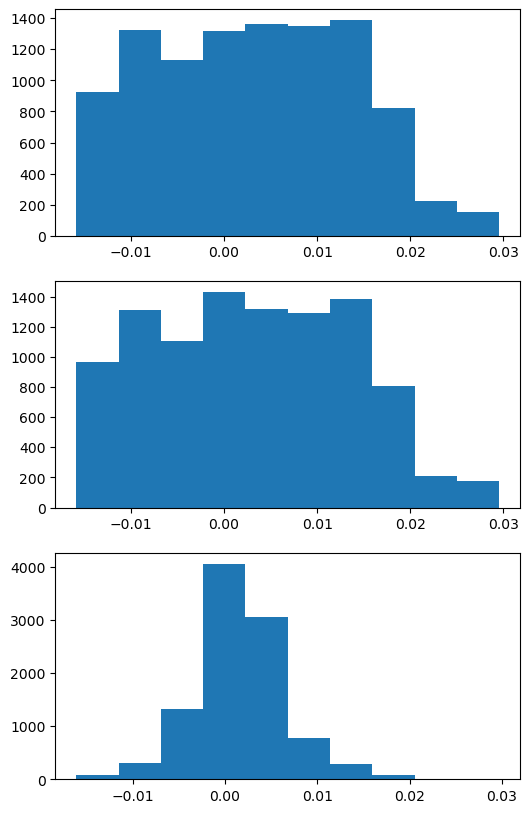

In [146]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))
ax[0].hist(linear_interpolation_from_data(test.iloc[0], 10_000))
ax[1].hist(linear_interpolation_from_data_2(test.iloc[[0]], 10_000, "Log Return").iloc[0])
ax[2].hist(kernel_denstity_estimation_based_sampling(test.iloc[0], 10_000, 0.00025))

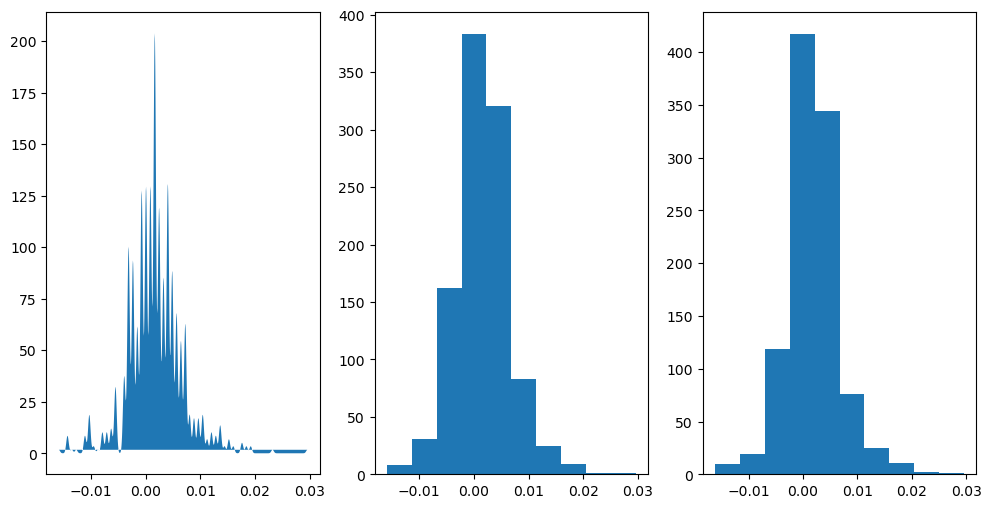

In [147]:
kde_test = KernelDensity(bandwidth=0.00023, kernel="gaussian")
test = llmtime_window_predictions["cact"][45]
kde_test_data = test.iloc[0].to_numpy()[:, None]
kde_test.fit(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)[:, None]
kde_results = kde_test.score_samples(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].fill(X_kde[:, 0], np.exp(kde_results))
ax[1].hist(test.iloc[0])
ax[2].hist(kde_test.sample(n_samples=2**10))

plt.show()

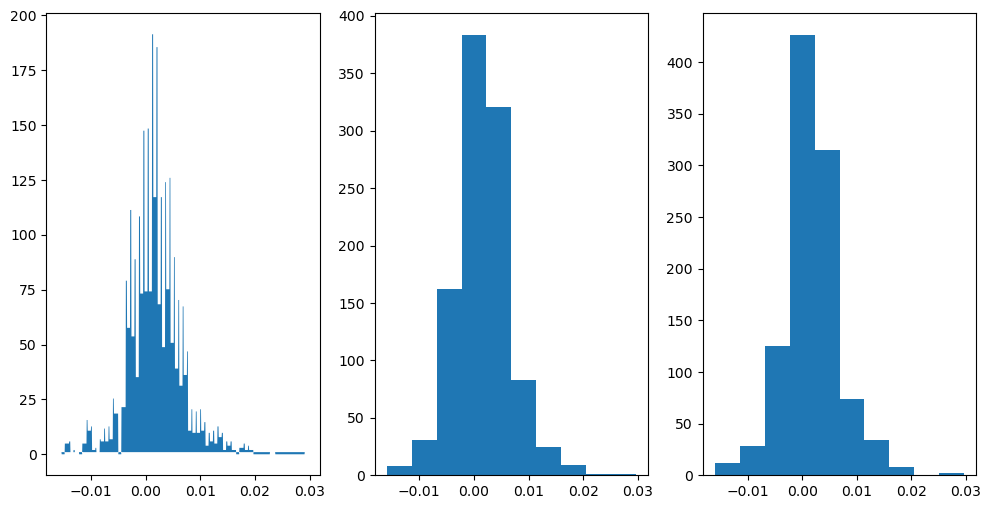

In [148]:
kde_test = KernelDensity(bandwidth=0.0005, kernel="tophat")
test = llmtime_window_predictions["cact"][45]
kde_test_data = test.iloc[0].to_numpy()[:, None]
kde_test.fit(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)[:, None]
kde_results = kde_test.score_samples(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].fill(X_kde[:, 0], np.exp(kde_results))
ax[1].hist(test.iloc[0])
ax[2].hist(kde_test.sample(n_samples=2**10))

plt.show()

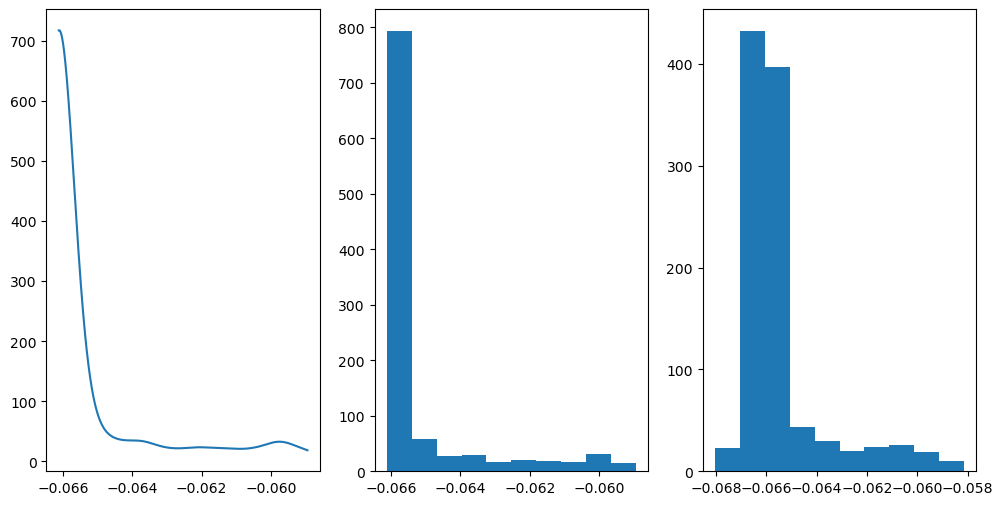

In [120]:
test = llmtime_window_predictions["cact"][45]
kde_test_data = test.iloc[0].to_numpy()
kde_test = gaussian_kde(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)
kde_results = kde_test.pdf(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].plot(X_kde, kde_results)
ax[1].hist(test.iloc[0])
ax[2].hist(kde_test.resample(size=2**10).squeeze(0))

plt.show()

In [119]:
kde_test.resample(size=2**10).squeeze(0)

array([-0.06681388, -0.06508559, -0.06593849, ..., -0.06505375,
       -0.06424403, -0.0665128 ])

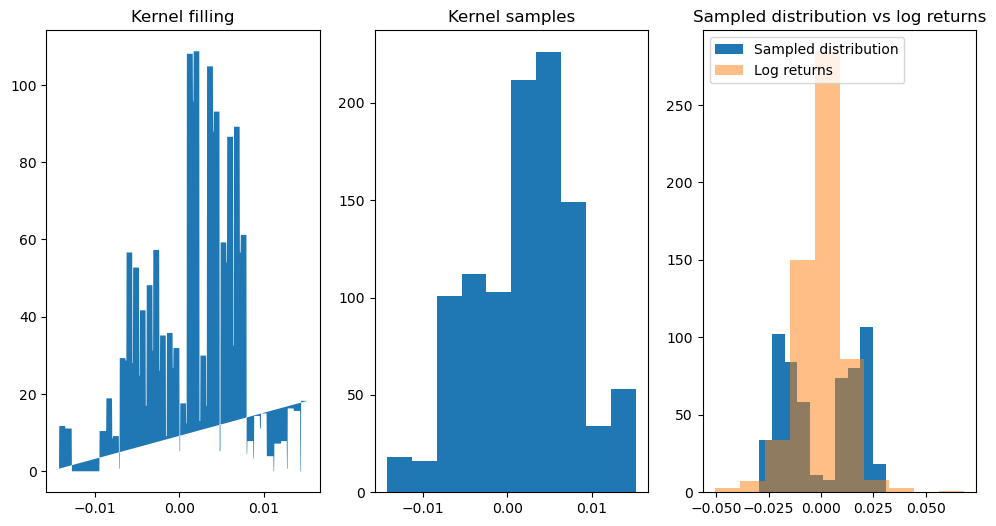

In [80]:
kde_test = KernelDensity(bandwidth=0.00075, kernel="tophat")
test = llmtime_window_predictions["cact"][45]
aligned_log_rets, _ = log_returns_dict["cact"].align(test, join="inner", axis=0)
kde_test_data = test.iloc[0].to_numpy()[:, None]
kde_test.fit(kde_test_data)
X_kde = np.linspace(kde_test_data.min(), kde_test_data.max(), num=2 ** 10)[:, None]
kde_results = kde_test.score_samples(X_kde)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].fill(X_kde[:, 0], np.exp(kde_results))
ax[0].set_title("Kernel filling")
ax[1].hist(test.iloc[0])
ax[1].set_title("Kernel samples")
kde_test_samples = kde_test.sample(n_samples=test.shape[0])
kde_samples_to_switch_indices = np.random.choice(range(len(kde_test_samples)), size=test.shape[0] // 2, replace=False)
kde_test_samples[kde_samples_to_switch_indices] -= 2 * np.abs(kde_test_samples[kde_samples_to_switch_indices] - mode(kde_test_samples)[0])
kde_test_samples += -kde_test_samples.mean() + aligned_log_rets.mean()
# kde_test_samples[kde_test_samples > 0] += np.abs(kde_test_samples[kde_test_samples > 0] - kde_test_samples.mean()) * (kde_test_samples[kde_test_samples > 0] + log_returns_dict["cact"].var())
# kde_test_samples[kde_test_samples < 0] -= np.abs(kde_test_samples[kde_test_samples < 0] - kde_test_samples.mean()) * (kde_test_samples[kde_test_samples < 0] - log_returns_dict["cact"].var())
# kde_test_samples += norm(loc=0, scale=log_returns_dict["cact"].var() - kde_test_samples.var()).rvs(size=kde_test_samples.shape)
ax[2].hist(kde_test_samples, label="Sampled distribution")
ax[2].hist(aligned_log_rets, alpha=0.5, label="Log returns")
ax[2].set_title("Sampled distribution vs log returns")
ax[2].legend(loc="upper left")
# test_samples_o1 = pd.read_excel("llm_o1_tests/2024-10-04_cact_o1_w=150.xlsx").set_index("Date")#.iloc[0]
# test_samples_o1 = pd.read_csv("llm_o1_tests/generated_samples_temp_cact_2024-10-07-21-21_w=150.csv", parse_dates=["Date"]).set_index("Date")#.iloc[0]
# ax[2].hist(test_samples_o1.sample(n=1, axis=1), alpha=0.5)


plt.show()

### $Z_2$ test

#### Description

A direct test for ES estimate. Does not assume a correct VaR specification.

#### Test statistic

From the unconditional definition of ES:

$$
\large ES_{\alpha, t} = -\mathop{\mathbb{E}} \left[ \frac{r_t I_t}{\alpha} \right]
$$

authors derive the following statistic:

$$
\large Z_2 = \sum_{t=1}^T \frac{I_t r_t}{T \alpha ES_{\alpha, t}} + 1
$$

with the following hypotheses:

$$
\large \begin{split}
    H_0:\text{ }&P_t^{[\alpha]} = F_t^{[\alpha]}, \forall t \\
    H_1:\text{ }&ES^F_{\alpha, t} \ge ES_{\alpha, t}\text{, for all }t\text{ and }\gt\text{ for some t} \\
    &VaR_t^F(\alpha) \ge VaR_t(\alpha)\text{, for all }t \\
\end{split}
$$

Again, we note that $\large \mathop{\mathbb{E}}_{H_0}[Z_2] = 0$ and $\large \mathop{\mathbb{E}}_{H_1}[Z_2] \lt 0$.

As opposed to $Z_1$, $Z_2$ tests both for exceedance frequency and magnitude <cite id="oolij"><a href="#zotero%7C12595123%2FUDNZXFSP">(Lazar &#38; Zhang, 2019)</a></cite>.

*We could take advantage of the stable $Z_2$ threshold, computed for significance levek $\eta \in \{5\%, 0.01\%\}$ <cite id="fbz75"><a href="#zotero%7C12595123%2FBTJLF7TJ">(Acerbi &#38; Szekely, 2014)</a></cite>, <cite id="oolij"><a href="#zotero%7C12595123%2FUDNZXFSP">(Lazar &#38; Zhang, 2019)</a></cite>.*

In [193]:
def acerbi_szekely_Z2_statistic(window: pd.DataFrame):
    actual_return = window[[col for col in window.columns if "returns" in col]]
    estimated_VaR = window["VaR"].bfill()
    estimated_ES = window["ES"].bfill()

    T = actual_return.shape[0]
    # Indicator function: I_t = 1 if VaR is exceeded computed for each return series
    I = actual_return.lt(estimated_VaR, axis=0).astype(int)

    Z2 = I * actual_return / (T * alpha_ES)
    Z2 = Z2.div(-estimated_ES, axis=0).sum(axis=0) + 1
    
    return Z2

def acerbi_szekely_Z2_test_process_llm(llmtime_test_ticker: str, llmtime_test_window: int):
    llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_VaR_ES_data = VaR_ES_llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
        llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
        how="inner", left_index=True, right_index=True
    ).merge(llmtime_VaR_ES_data, how="inner", left_index=True, right_index=True)

    acerbi_test_statistic = acerbi_szekely_Z2_statistic(llmtime_test_data).iloc[0]
    acerbi_windowed_Z2_results = acerbi_szekely_simulation(
        simulator=empirical_kde_based_simulator, statistic_calculator=acerbi_szekely_Z2_statistic,
        data=llmtime_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=("distribution", 0.0005,), asset=llmtime_test_ticker
    )

    return llmtime_test_ticker, f"llmtime_{llmtime_test_window}", acerbi_windowed_Z2_results, acerbi_test_statistic

def acerbi_szekely_Z2_test_process_other_methods(estimator: str, asset: str):
    window_VaR_test_data = VaR_predictions[estimator][asset]
    window_ES_test_data = ES_predictions[estimator][asset]
    window_volatility = volatility_predictions[estimator][asset]
    window_acerbi_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
        window_VaR_test_data.rename("VaR"), how="inner", left_index=True, right_index=True
    ).merge(
        window_ES_test_data.rename("ES"), how="inner", left_index=True, right_index=True
    ).merge(
        window_volatility.rename("volatility"), how="inner", left_index=True, right_index=True
    )

    # Rescale if using GARCH LPA
    if estimator == "garch_lpa":
        window_acerbi_test_data = window_acerbi_test_data.merge(garch_lpa_rescaling_dict[asset], how="inner", left_index=True, right_index=True)

    volatility_distribution_estimator_name = "_".join(estimator.split("_")[:-1]) if re.match(r".*?_\d+", estimator) else estimator
    window_volatility_residual_distribution = volatility_distributions[volatility_distribution_estimator_name]
    acerbi_test_statistic = acerbi_szekely_Z2_statistic(window_acerbi_test_data).iloc[0]
    acerbi_windowed_Z2_results = acerbi_szekely_simulation(
        simulator=volatility_based_simulator, statistic_calculator=acerbi_szekely_Z2_statistic,
        data=window_acerbi_test_data, n_simulations=acerbi_backtesting_test_statistic_simulations,
        simulator_params=(window_volatility_residual_distribution,), asset=asset
    )

    return asset, estimator, acerbi_windowed_Z2_results, acerbi_test_statistic

In [194]:
with tqdm_joblib(tqdm(desc="Z2 ES LLM...", total=count_estimations(llmtime_window_predictions))) as progress_bar:
    ES_Z2_backtest_results = Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z2_test_process_llm)(llmtime_test_ticker, llmtime_test_window)
        for llmtime_test_ticker in llmtime_window_predictions.keys()
        for llmtime_test_window in llmtime_window_predictions[llmtime_test_ticker].keys()
    )

with tqdm_joblib(tqdm(desc="Z2 ES other methods...", total=count_estimations(volatility_predictions))) as progress_bar:
    ES_Z2_backtest_results += Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z2_test_process_other_methods)(estimator, asset)
        for estimator, asset_window_volatility_dict in volatility_predictions.items()
        for asset, window_volatility in asset_window_volatility_dict.items()
    )

ES_Z2_backtest_results_df = pd.DataFrame(ES_Z2_backtest_results).pivot_table(index=[1], columns=[0], values=[2], aggfunc=lambda x: x, sort=False)
ES_Z2_backtest_results_df.index.name = ""
ES_Z2_backtest_results_df.columns = ES_Z2_backtest_results_df.columns.get_level_values(0)

ES_Z2_test_statistic_df = pd.DataFrame(ES_Z2_backtest_results).pivot_table(index=[1], columns=[0], values=[3], aggfunc=lambda x: x, sort=False)
ES_Z2_test_statistic_df.index.name = ""
ES_Z2_test_statistic_df.columns = ES_Z2_test_statistic_df.columns.get_level_values(0)

Z2 ES other methods...: 100%|██████████| 117/117 [00:16<00:00,  7.11it/s]


In [213]:
llmtime_test_ticker, llmtime_test_window = "gdaxi", 30
llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
llmtime_VaR_ES_data = VaR_ES_llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
    llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
    how="inner", left_index=True, right_index=True
).merge(llmtime_VaR_ES_data, how="inner", left_index=True, right_index=True)

acerbi_test_statistic = acerbi_szekely_Z2_statistic(llmtime_test_data).iloc[0]

In [223]:
plt.get_cmap("tab10")(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [224]:
plt.get_cmap("tab10")(3)

(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)

In [195]:
ES_Z2_backtest_results_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,0.00000,0.00000,0.00000,0.00000,0.99975,0.00000,0.00000,0.00000,0.00000
llmtime_150,0.99005,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
llmtime_30,0.00135,0.00000,0.99700,0.00000,0.00000,0.00110,1.00000,0.00000,0.00000
llmtime_60,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
llmtime_45,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
llmtime_90,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
garch_lpa,0.11425,0.21050,0.11570,0.52450,0.87330,0.05015,0.37320,0.11790,0.30520
ewma_normal_80,0.01055,0.03115,0.01420,0.35635,0.18240,0.00120,0.00750,0.00000,0.01135
ewma_normal_120,0.03645,0.03445,0.05060,0.09325,0.07190,0.00785,0.08155,0.00000,0.24415


In [196]:
ES_Z2_test_statistic_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,-5.020992,-3.533973,-4.143120,-2.623225,10.287878,-5.862716,-4.191155,-6.644657,-4.595756
llmtime_150,5.312311,-3.055215,-3.481790,-2.497537,-3.351716,-6.931741,-5.138714,-6.744268,-4.350845
llmtime_30,-3.555387,-4.189543,1.564359,-4.624863,-4.083520,-7.906823,16.495477,-5.996595,-9.837815
llmtime_60,-3.140773,-4.233875,-4.191381,-3.337009,-3.392152,-4.632546,-3.916367,-4.602377,-3.352792
llmtime_45,-4.001616,-3.327558,-3.540418,-3.134587,-3.310843,-4.790552,-3.417901,-3.892701,-3.831560
llmtime_90,-5.035707,-3.174887,-3.991304,-2.617753,-3.501776,-4.913141,-4.130647,-5.085124,-3.625646
garch_lpa,0.227618,0.295779,0.161696,0.554144,0.727623,0.023319,0.383712,0.222131,0.340132
ewma_normal_80,0.036664,0.152173,0.075581,0.484948,0.369183,-0.169330,0.013015,-0.439757,0.053655
ewma_normal_120,0.150586,0.143039,0.188255,0.266670,0.226980,-0.018525,0.246769,-0.439757,0.404933


In [159]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_Z2_df = ES_Z2_backtest_results_df
ES_Z2_statistic_df = ES_Z2_test_statistic_df

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_Z2_df.index = (ES_Z2_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))
ES_Z2_statistic_df.index = (ES_Z2_statistic_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_Z2_df.columns = ES_Z2_df.columns.str.upper().str.replace('_', '.')
ES_Z2_statistic_df.columns = ES_Z2_statistic_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_Z2_df.index = ES_Z2_df.index.str.upper().str.replace('_', '.')
ES_Z2_statistic_df.index = ES_Z2_statistic_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_Z2_df = ES_Z2_df[asset_table_ordering]
ES_Z2_statistic_df = ES_Z2_statistic_df[asset_table_ordering]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(statistic, p_value):
    # Use a gradient of green and red based on the value
    if p_value > 0.05:
        if p_value > 0.5:
            color = "green!70!white"  # Darker green for higher values
        else:
            color = "green!30!white"  # Lighter green for values near 0.05
    else:
        if p_value < 0.01:
            color = "red!70!white"  # Darker red for lower values
        else:
            color = "red!30!white"  # Lighter red for values near 0.05
    return f"\\cellcolor{{{color}}} {statistic:.3f}"

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_Z2_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_Z2_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for (idx, pvalues), (_, statistics) in zip(ES_Z2_df.iterrows(), ES_Z2_statistic_df.iterrows()):
    latex_code += f"{idx} & " + " & ".join([format_value(statistic, pval) for statistic, pval in zip(statistics, pvalues)]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_Z2_df.to_csv(results_directory / "ES_Z2.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_Z2.tex", "w") as f:
    f.write(latex_code)
    

### $Z_3$ test

#### Description

Expects correct spread of the conditional distribution "ranking" (CDF values) for actual log returns, with an emphasis on the ES tails.

#### Test statistic

Define the empirical ES estimate:

$$
\large \widehat{ES}_{\alpha}^{(N)}(Y) = -\frac{1}{\lfloor N \alpha \rfloor} \sum_{i=1}^{\lfloor N \alpha \rfloor} Y_{i:N}
$$

$U = (P_t(r))_t$ is expected to be i.i.d. $Uniform(0, 1)$ distributed.

To this end, authors propose the following statistic:

$$
\large Z_3 = - \frac{1}{T} \sum_{t=1}^T \frac{\widehat{ES}_{\alpha}^{(T)}(P^{-1}_t(U)}{\mathop{\mathbb{E}}_{V} \left[\widehat{ES}_{\alpha}^{(T)}(P^{-1}_t(V)) \right]} + 1
$$

where $V \sim Uniform (0, 1)$.

$U$ is computed for the conditional distribution of each day using all historical returns and used in the numerator.

The denominator is shown to be equivalent to

$$
\large -\frac{T}{\lfloor T \alpha \rfloor} \int_0^1 I_{1 - p} (T - \lfloor T \alpha \rfloor, \lfloor T \alpha \rfloor) P^{-1}_t(p) dp
$$

where $I_{1-x}(a, b)$ is the incomplete regularized Beta function.

We use Simpson's method for approximating the integral.

Similarly to the other two tests, $\large  \mathop{\mathbb{E}}_{H_0}[Z_3] = 0$ and $\large \mathop{\mathbb{E}}_{H_1}[Z_3] \lt 0$.

#### Caveats

*My first gut was that LLM couldn't pass this test because its empirical CDF ususlly outputs very high probabilities, not uniform, as assumed. However, because this test focuses on the tail values, in probably works because of the overall high empirical probabilities.*

Because the test is computationally demanding and the LLM part is not entirely optimized, it will run on less simulations than the rest.
*Keep in mind to set `acerbi_backtesting_test_statistic_n_jobs` accordingly to your system. This test in particular requires a lot of RAM. You can also lower the `batch_size` argument inside the test statistic function for other models, `acerbi_szekely_Z3_statistic_other_methods()`. *

In [186]:
def empirical_inverse_cdf_ES(distribution: pd.Series, quantiles: pd.Series, sample_size: int):
    sorted_distribution = distribution.sort_values(ascending=True)
    distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
    inverse_cdf_samples = sorted_distribution.iloc[distribution_indices].sort_values(ascending=True)
    return -inverse_cdf_samples.iloc[:int(alpha_ES * sample_size)].mean()

def compute_integral_empirical_inverse_trapezium(distribution: pd.Series, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    def inverse_empirical_cdf(distribution: pd.Series, quantiles: pd.Series):
        sorted_distribution = distribution.sort_values(ascending=True)
        distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
        return sorted_distribution.iloc[distribution_indices].to_numpy()
    rectangles = np.linspace(0, 1, num=n_rectangles)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * inverse_empirical_cdf(distribution, rectangles)
    return  ((lengths[0] / 2 + lengths[1:-1].sum() + lengths[-1] / 2) * width).sum()

def compute_integral_empirical_inverse_simpson(distribution: pd.Series, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    def inverse_empirical_cdf(distribution: pd.Series, quantiles: pd.Series):
        sorted_distribution = distribution.sort_values(ascending=True)
        distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
        empirical_distribution_correct = sorted_distribution.iloc[distribution_indices].to_numpy()
        return sorted_distribution.iloc[distribution_indices].to_numpy()
    n_rectangles = n_rectangles - (n_rectangles % 2)
    rectangles = np.linspace(0, 1, num=n_rectangles)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * inverse_empirical_cdf(distribution, rectangles)
    return  ((lengths[0] + 4 * lengths[1:-1:2].sum() + 2 * lengths[2:-1:2].sum() + lengths[-1]) * width / 3).sum()

def inverse_empirical_cdf(distribution: pd.Series, quantiles: pd.Series):
    sorted_distribution = distribution.sort_values(ascending=True)
    distribution_indices = np.clip((sorted_distribution.shape[0] * quantiles).astype(int), 0, sorted_distribution.shape[0] - 1)
    return sorted_distribution.iloc[distribution_indices].to_numpy()

# Not used
# Reference when the faster method was developed
def acerbi_szekely_Z3_statistic_llm_slow(window: pd.DataFrame):
    acerbi_Z3_results = []
    return_columns = [col for col in window.columns if "return" in col]
    empirical_distribution_columns = [col for col in window.columns if "distribution" in col]

    for return_col in return_columns:
        # Compute quantiles $P_t^{-1}(r_t)$
        window_quantiles = (
            window[empirical_distribution_columns].lt(window[return_col], axis=0).sum(axis=1) / len(empirical_distribution_columns)
        )
        # Compute empirical ES on the quantile inverse CDF
        empirical_ES = window[empirical_distribution_columns].apply(
            lambda row: empirical_inverse_cdf_ES(row, window_quantiles, window.shape[0]), 
            axis=1
        )

        # Compute denominators for each day - we use Simpson's rule, although trapezium gives the same result for a large number of evaluations
        betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])        
        denominator = window[empirical_distribution_columns].apply(
            lambda row:  -window.shape[0] / betainc_b * compute_integral_empirical_inverse_simpson(row, a=betainc_a, b=betainc_b, n_rectangles=1_000),
            axis=1
        )
        # Compute the test statistic
        acerbi_Z3_results.append(- 1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum() + 1)

    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_statistic_llm(window: pd.DataFrame):
    from scipy.special import betainc
    acerbi_Z3_results = []
    return_columns = [col for col in window.columns if "return" in col]
    empirical_distribution_columns = [col for col in window.columns if "distribution" in col]

    # Compute denominator integral - we use Simpson's rule because of better asymptotics, although trapezium gives the same result
    # Speedup is noticeable, however memory cost also increases more than linearly by the number of rectangles
    n_rectangles = 1_000
    # Even number of rectangles for Simpson
    n_rectangles = n_rectangles - (n_rectangles % 2)
    betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])     
    rectangles = np.linspace(0, 1, num=n_rectangles)
    width = np.diff(rectangles)[0]
    empirical_distributions = np.sort(window[empirical_distribution_columns].to_numpy(), axis=1)
    empirical_cdf_indices = np.clip((empirical_distributions.shape[1] * rectangles).astype(int), 0, empirical_distributions.shape[1] - 1)
    lengths_daily = betainc(betainc_a, betainc_b, 1 - rectangles)[None, :] * empirical_distributions[:, empirical_cdf_indices]
    denominator = -window.shape[0] / betainc_b * (
        (lengths_daily[:, 0] + 4 * lengths_daily[:, 1:-1:2].sum(axis=1) + 2 * lengths_daily[:, 2:-1:2].sum(axis=1) + lengths_daily[:, -1]) * width / 3
    )
    denominator = pd.Series(denominator, index=window.index)

    for return_col in return_columns:
        # Compute quantiles $P_t^{-1}(r_t)$
        window_quantiles = (
            window[empirical_distribution_columns].lt(window[return_col], axis=0).sum(axis=1) / len(empirical_distribution_columns)
        )
        # Compute empirical ES on the quantile inverse CDF
        empirical_ES = window[empirical_distribution_columns].apply(
            lambda row: empirical_inverse_cdf_ES(row, window_quantiles, window.shape[0]), 
            axis=1
        )

        # Compute the test statistic
        acerbi_Z3_results.append(- 1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum() + 1)

    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_test_process_llm(llmtime_test_ticker: str, llmtime_test_window: int):
    llmtime_test_data = llmtime_window_predictions[llmtime_test_ticker][llmtime_test_window]
    llmtime_test_data = log_returns_dict[llmtime_test_ticker].to_frame(name="returns").merge(
        llmtime_test_data.rename(columns={f"Log Return {i}": f"distribution_{i}" for i in range(1, llmtime_test_data.shape[1] + 1)}),
        how="inner", left_index=True, right_index=True
    )

    acerbi_test_statistic = acerbi_szekely_Z3_statistic_llm(llmtime_test_data).iloc[0]
    acerbi_windowed_Z3_results = acerbi_szekely_simulation(
        simulator=empirical_kde_based_simulator, statistic_calculator=acerbi_szekely_Z3_statistic_llm,
        data=llmtime_test_data, n_simulations=1_000, #acerbi_backtesting_test_statistic_simulations,
        simulator_params=("distribution", 0.0005,), asset=llmtime_test_ticker, add_all_columns_to_simulation=True
    )

    return llmtime_test_ticker, f"llmtime_{llmtime_test_window}", acerbi_windowed_Z3_results, acerbi_test_statistic

In [187]:
def empirical_volatility_ES(variance: float, quantiles: pd.Series, distribution: Callable, rescale_mean: float, rescale_std: float):
    inverse_cdf_samples = np.sort(distribution(loc=0, scale=np.sqrt(variance)).ppf(quantiles))
    inverse_cdf_samples = (inverse_cdf_samples * rescale_std) + rescale_mean
    return -inverse_cdf_samples[:int(alpha_ES * quantiles.shape[0])].mean()

def compute_integral_distribution_trapezium(variance: float, distribution: Callable, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    rectangles = np.linspace(1 / n_rectangles, 1, num=n_rectangles, endpoint=False)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * distribution(loc=0, scale=np.sqrt(variance)).ppf(rectangles)
    return  ((lengths[0] / 2 + lengths[1:-1].sum() + lengths[-1] / 2) * width).sum()

def compute_integral_distribution_simpson(variance: float, distribution: Callable, a: float, b: float, n_rectangles: int):
    from scipy.special import betainc
    n_rectangles = n_rectangles - (n_rectangles % 2)
    rectangles = np.linspace(1 / n_rectangles, 1, num=n_rectangles, endpoint=False)
    width = np.diff(rectangles)[0]
    lengths = betainc(a, b, 1 - rectangles) * distribution(loc=0, scale=np.sqrt(variance)).ppf(rectangles)
    return  ((lengths[0] + 4 * lengths[1:-1:2].sum() + 2 * lengths[2:-1:2].sum() + lengths[-1]) * width / 3).sum()

# Not used
# Reference when the faster method was developed
def acerbi_szekely_Z3_statistic_other_methods_slow(window: pd.DataFrame, distribution: Callable[[float, float], Any]):
    acerbi_Z3_results = []
    return_columns = [col for col in window.columns if "return" in col]
    for return_col in return_columns:
        # Compute quantiles $P_t^{-1}(r_t)$
        window_quantiles = window.apply(
            lambda row: distribution(loc=0, scale=np.sqrt(row["volatility"])).cdf((row[return_col] - row["rescale_mean"]) / row["rescale_std"]),
            axis=1
        )
        # Compute empirical ES on the quantile inverse CDF
        empirical_ES = window.apply(
            lambda row: empirical_volatility_ES(row["volatility"], window_quantiles, distribution, row["rescale_mean"], row["rescale_std"]),
            axis=1
        )
    
        # Compute denominators for each day - we use Simpson's rule, although trapezium gives the same result for a large number of evaluations
        betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])        
        denominator = window["volatility"].map(
            lambda row:  -window.shape[0] / betainc_b * compute_integral_distribution_simpson(row, distribution=distribution, a=betainc_a, b=betainc_b, n_rectangles=1_000)
        )
    
        # Compute the test statistic
        acerbi_Z3_results.append(- 1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum() + 1)
    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_statistic_other_methods(window: pd.DataFrame, distribution: Callable[[float, float], Any]):
    from scipy.special import betainc
    return_columns = [col for col in window.columns if "return" in col]

    # Compute all quantiles at once for the standardized distribution and then multiply by the daily standard deviation
    window_std_deviations = np.sqrt(window["volatility"]).to_numpy()
    standardized_returns = window[return_columns].subtract(window["rescale_mean"], axis=0).div(window["rescale_std"], axis=0).to_numpy()
    window_quantiles = distribution(loc=0, scale=1).cdf(standardized_returns / window_std_deviations[:, None])

    # Compute and invert quantiles at once for the standardized distribution
    # Uses the location-mean nature of our distributions
    # Copy quantiles to form a 3D array of size (day, return_col, quantiles) for faster processing
    # Batched processing (1 item in batch = 1 return col) because the full array does not fit into memory
    # Decrease if memory issues occur
    batch_size = 3
    empirical_ES = np.zeros_like(window_quantiles, dtype="float64")
    rescale_std = window["rescale_std"].to_numpy()
    rescale_mean = window["rescale_mean"].to_numpy()
    for batch_index in range(0, len(return_columns), batch_size):
        window_quantiles_slice = distribution(loc=0, scale=1).ppf(window_quantiles[:, batch_index:batch_index + batch_size, None])
        window_quantiles_slice = np.tile(window_quantiles_slice, (1, 1, window.shape[0]))
        window_inverse_quantiles = window_quantiles_slice * window_std_deviations[None, None, :]
        window_inverse_quantiles = np.sort((window_inverse_quantiles * rescale_std[None, None, :]) + rescale_mean[None, None, :], axis=0)
    
        # Compute empirical ES
        empirical_ES[:, batch_index:batch_index + batch_size] = -window_inverse_quantiles[:int(alpha_ES * window.shape[0]), :, :].mean(axis=0).T
    empirical_ES = pd.DataFrame(empirical_ES, index=window.index, columns=return_columns)

    # Compute denominator integral - we use Simpson's rule because of better asymptotics, although trapezium gives the same result
    # Speedup is noticeable, however memory cost also increases more than linearly by the number of rectangles
    n_rectangles = 1_000
    # Even number of rectangles for Simpson
    n_rectangles = n_rectangles - (n_rectangles % 2)
    betainc_a, betainc_b = window.shape[0] - int(alpha_ES * window.shape[0]), int(alpha_ES * window.shape[0])     
    rectangles = np.linspace(1 / n_rectangles, 1, num=n_rectangles, endpoint=False)
    width = np.diff(rectangles)[0]
    lengths = betainc(betainc_a, betainc_b, 1 - rectangles) * distribution(loc=0, scale=1).ppf(rectangles)
    lengths_daily = np.tile(lengths[:, None], (1, window.shape[0])).reshape(-1, window.shape[0]).T
    lengths_daily_test = lengths_daily.copy()
    lengths_daily = lengths_daily * window_std_deviations[:, None]
    denominator = -window.shape[0] / betainc_b * (
        (lengths_daily[:, 0] + 4 * lengths_daily[:, 1:-1:2].sum(axis=1) + 2 * lengths_daily[:, 2:-1:2].sum(axis=1) + lengths_daily[:, -1]) * width / 3
    )
    denominator = pd.Series(denominator, index=window.index)
    
    # Compute the test statistic
    acerbi_Z3_results = -1 / window.shape[0] * empirical_ES.div(denominator, axis=0).sum(axis=0) + 1
    return pd.Series(acerbi_Z3_results, index=return_columns)

def acerbi_szekely_Z3_test_process_other_methods(estimator: str, asset: str):
    window_volatility = volatility_predictions[estimator][asset]
    window_acerbi_test_data = log_returns_dict[asset].to_frame(name="returns").merge(
        window_volatility.rename("volatility"), how="inner", left_index=True, right_index=True
    )

    # Rescale if using GARCH LPA
    if estimator == "garch_lpa":
        window_acerbi_test_data = window_acerbi_test_data.merge(garch_lpa_rescaling_dict[asset], how="inner", left_index=True, right_index=True)
    else:
        window_acerbi_test_data["rescale_mean"] = 0
        window_acerbi_test_data["rescale_std"] = 1

    volatility_distribution_estimator_name = "_".join(estimator.split("_")[:-1]) if re.match(r".*?_\d+", estimator) else estimator
    window_volatility_residual_distribution = volatility_distributions[volatility_distribution_estimator_name]
    if window_volatility_residual_distribution == "normal":
        volatility_distribution_func = lambda loc, scale: norm(loc=loc, scale=scale)
    else:
        volatility_distribution_func = lambda loc, scale: t(loc=loc, scale=scale, df=t_nu)
        
    acerbi_test_statistic = acerbi_szekely_Z3_statistic_other_methods(window_acerbi_test_data, volatility_distribution_func).iloc[0]
    acerbi_windowed_Z3_results = acerbi_szekely_simulation(
        simulator=volatility_based_simulator, statistic_calculator=acerbi_szekely_Z3_statistic_other_methods,
        data=window_acerbi_test_data, n_simulations=1_000,
        simulator_params=(window_volatility_residual_distribution,), statistic_calculator_params=(volatility_distribution_func,), 
        add_all_columns_to_simulation=True, asset=asset
    )

    return asset, estimator, acerbi_windowed_Z3_results, acerbi_test_statistic

In [192]:
with tqdm_joblib(tqdm(desc="Z3 ES LLM...", total=count_estimations(llmtime_window_predictions))) as progress_bar:
    ES_Z3_backtest_results = Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z3_test_process_llm)(llmtime_test_ticker,
                                                    llmtime_test_window)
        for llmtime_test_ticker in llmtime_window_predictions.keys()
        for llmtime_test_window in llmtime_window_predictions[llmtime_test_ticker].keys()
    )

with tqdm_joblib(tqdm(desc="Z3 ES other methods...", total=count_estimations(volatility_predictions))) as progress_bar:
    ES_Z3_backtest_results += Parallel(prefer="processes", verbose=0, n_jobs=acerbi_szekely_n_jobs())(
        delayed(acerbi_szekely_Z3_test_process_other_methods)(estimator, asset)
        for estimator, asset_window_volatility_dict in volatility_predictions.items()
        for asset, window_volatility in asset_window_volatility_dict.items()
    )

ES_Z3_backtest_results_df = pd.DataFrame(ES_Z3_backtest_results).pivot_table(index=[1], columns=[0], values=[2], aggfunc=lambda x: x, sort=False)
ES_Z3_backtest_results_df.index.name = ""
ES_Z3_backtest_results_df.columns = ES_Z3_backtest_results_df.columns.get_level_values(0)

ES_Z3_test_statistic_df = pd.DataFrame(ES_Z3_backtest_results).pivot_table(index=[1], columns=[0], values=[3], aggfunc=lambda x: x, sort=False)
ES_Z3_test_statistic_df.index.name = ""
ES_Z3_test_statistic_df.columns = ES_Z3_test_statistic_df.columns.get_level_values(0)

Z3 ES LLM...: 100%|██████████| 54/54 [00:05<00:00,  9.76it/s]


KeyboardInterrupt: 

In [189]:
ES_Z3_backtest_results_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_150,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_60,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_45,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
llmtime_90,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
garch_lpa,0.999,0.942,0.997,0.978,0.982,0.998,1.000,0.895,0.998
ewma_normal_80,0.011,0.003,0.000,0.194,0.123,0.000,0.001,0.000,0.000
ewma_normal_120,0.038,0.000,0.006,0.100,0.048,0.000,0.001,0.000,0.003


In [190]:
ES_Z3_test_statistic_df

,djci,SPGTCLTR,gdaxi,SP500,cbu,ftse,stoxx,CRIX,cact
,,,,,,,,,
llmtime_120,-0.498444,-0.454604,-0.630999,-0.606220,-0.353391,-0.745168,-0.577992,-0.997992,-0.595781
llmtime_150,-0.345273,-0.483940,-0.660852,-0.442740,-0.441485,-0.671794,-0.588177,-0.954787,-0.590894
llmtime_30,-0.311859,-0.307451,-0.420878,-0.383898,-0.326080,-0.476973,-0.476296,-0.613227,-0.572292
llmtime_60,-0.473151,-0.591631,-0.573128,-0.363036,-0.442152,-0.647948,-0.550527,-0.835623,-0.571907
llmtime_45,-0.525763,-0.452449,-0.528113,-0.342517,-1.443829,-0.566589,-0.497773,-0.738351,-0.527553
llmtime_90,1.432001,-0.500039,-0.601449,-0.408870,-0.424870,-0.622857,-0.564093,-0.928184,-0.588702
garch_lpa,0.989126,0.981722,0.987949,0.987923,0.994744,0.991400,0.990716,0.958729,0.988734
ewma_normal_80,-0.214115,-0.261985,-0.266097,-0.120136,-0.141036,-0.445253,-0.340695,-0.509100,-0.364019
ewma_normal_120,-0.190142,-0.302709,-0.235733,-0.146140,-0.173382,-0.384268,-0.254596,-0.509100,-0.247113


In [191]:
import pandas as pd


# Assuming backtest_christoffersen is already defined
ES_Z3_df = ES_Z3_backtest_results_df
ES_Z3_statistic_df = ES_Z3_test_statistic_df

# Convert columns to uppercase and replace "NORMAL" with "N"
# Convert index (rows) to uppercase, replace "LLMTIME" with "LLM"
ES_Z3_df.index = (ES_Z3_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))
ES_Z3_statistic_df.index = (ES_Z3_statistic_df.index.str.upper()
                          .str.replace("NORMAL", "N")
                          .str.replace("LLMTIME", "LLM")
                          .str.replace('_', '.'))

# Convert columns to uppercase and replace underscores with dots
ES_Z3_df.columns = ES_Z3_df.columns.str.upper().str.replace('_', '.')
ES_Z3_statistic_df.columns = ES_Z3_statistic_df.columns.str.upper().str.replace('_', '.')

# Convert index (rows) to uppercase and replace underscores with dots
ES_Z3_df.index = ES_Z3_df.index.str.upper().str.replace('_', '.')
ES_Z3_statistic_df.index = ES_Z3_statistic_df.index.str.upper().str.replace('_', '.')

# Reorder columns for consistency
ES_Z3_df = ES_Z3_df[asset_table_ordering]
ES_Z3_statistic_df = ES_Z3_statistic_df[asset_table_ordering]

# Define a function to format numbers to 3 decimals and apply green-red palette
def format_value(statistic, p_value):
    # Use a gradient of green and red based on the value
    if p_value > 0.05:
        if p_value > 0.5:
            color = "green!70!white"  # Darker green for higher values
        else:
            color = "green!30!white"  # Lighter green for values near 0.05
    else:
        if p_value < 0.01:
            color = "red!70!white"  # Darker red for lower values
        else:
            color = "red!30!white"  # Lighter red for values near 0.05
    return f"\\cellcolor{{{color}}} {statistic:.3f}"

# Create LaTeX table manually
latex_code = "\\begin{tabular}{l" + "r" * len(ES_Z3_df.columns) + "}\n"
latex_code += " \\toprule\n"
latex_code += "\\textbf{Model} & " + " & ".join([f"\\textbf{{{col}}}" for col in ES_Z3_df.columns]) + " \\\\\n"
latex_code += " \\midrule\n"

# Generate LaTeX table content, iterating through the DataFrame with 2 decimal formatting and color coding
for (idx, pvalues), (_, statistics) in zip(ES_Z3_df.iterrows(), ES_Z3_statistic_df.iterrows()):
    latex_code += f"{idx} & " + " & ".join([format_value(statistic, pval) for statistic, pval in zip(statistics, pvalues)]) + " \\\\\n"
latex_code += " \\bottomrule\n"
latex_code += "\\end{tabular}"

# Export the DataFrame to CSV
ES_Z3_df.to_csv(results_directory / "ES_Z3.csv")

# Write the LaTeX code to a .tex file
with open(results_directory / "ES_Z3.tex", "w") as f:
    f.write(latex_code)
    

# Determine test LLM window

In [197]:
experiments_simulations_directory =  Path("llm_window_tests")
extra_llmtime_window_predictions = {
    asset: read_llmtime_simulations(asset, experiments_simulations_directory) 
    for asset in tqdm(read_llmtime_assets(experiments_simulations_directory), desc="Reading experiments...")
}

Reading experiments...: 100%|██████████| 4/4 [01:06<00:00, 16.62s/it]


In [ ]:
llmtime

In [57]:
llm_failure_rates = pd.DataFrame.from_dict([backtest_failure_rates[estimator] for estimator in backtest_failure_rates.keys() if "llmtime" in estimator])["CRIX"]
llm_failure_rates.index = llm_failure_rates.index.map(lambda text: int(text.split("_")[1]))
llm_failure_rates = llm_failure_rates.sort_index()

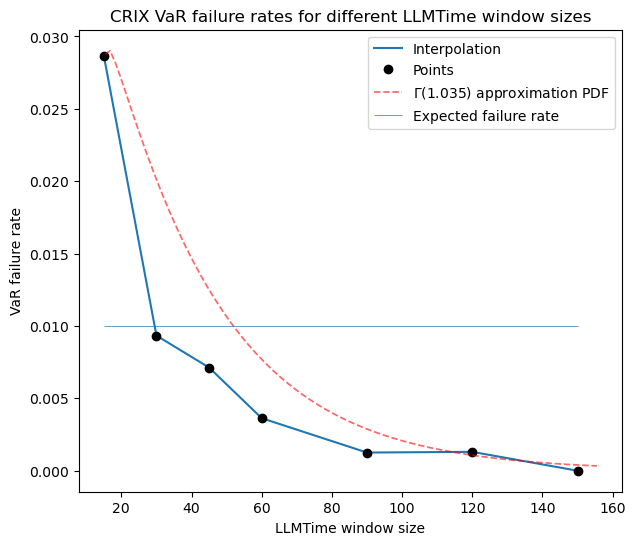

In [125]:
plt.figure(figsize=(7, 6))

llm_failure_rates.plot.line(label="Interpolation")
llm_points = llm_failure_rates.to_dict()
plt.plot(list(llm_points.keys()), list(llm_points.values()), 'ko', label="Points")
a = (1.035, 15, 30)
x = np.linspace(gamma.ppf(0.01, *a), gamma.ppf(0.99, *a), 100)
plt.plot(x, gamma.pdf(x, *a), 'r--', lw=1.25, alpha=0.6, label=r'$\Gamma(1.035)$ approximation PDF')
plt.hlines(0.01, xmin=15, xmax=150, lw=0.5, linestyle="-", label="Expected failure rate")

plt.title("CRIX VaR failure rates for different LLMTime window sizes")
plt.xlabel("LLMTime window size")
plt.ylabel("VaR failure rate")
plt.legend()

plt.savefig("workshop/failure_rate_plot.png", bbox_inches="tight")

# Bibliography

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|12595123/BTJLF7TJ"></i>Acerbi, C., &#38; Szekely, B. (2014). Back-testing expected shortfall. <i>Risk</i>, <i>27</i>(11), 76–81.</div>
  <div class="csl-entry"><i id="zotero|12595123/A9UGX7MM"></i>Acerbi, C., &#38; Székely, B. (2023). Backtestability and the ridge backtest. <i>Frontiers of Mathematical Finance</i>, <i>2</i>(4), 497–521. <a href="https://doi.org/10.3934/fmf.2023019">https://doi.org/10.3934/fmf.2023019</a></div>
  <div class="csl-entry"><i id="zotero|12595123/T2GHH5LV"></i>Alexander, C., &#38; Dakos, M. (2023). Assessing the accuracy of exponentially weighted moving average models for Value-at-Risk and Expected Shortfall of crypto portfolios. <i>Quantitative Finance</i>, <i>23</i>(3), 393–427. <a href="https://doi.org/10.1080/14697688.2022.2159505">https://doi.org/10.1080/14697688.2022.2159505</a></div>
  <div class="csl-entry"><i id="zotero|12595123/SYW4CGYB"></i>Bayer, S., &#38; Dimitriadis, T. (2022). Regression-Based Expected Shortfall Backtesting. <i>Journal of Financial Econometrics</i>, <i>20</i>(3), 437–471. <a href="https://doi.org/10.1093/jjfinec/nbaa013">https://doi.org/10.1093/jjfinec/nbaa013</a></div>
  <div class="csl-entry"><i id="zotero|12595123/66IRPRTK"></i>Benito Muela, S., López-Martin, C., &#38; Arguedas-Sanz, R. (2023). A comparison of market risk measures from a twofold perspective: accurate and loss function. <i>ACRN Journal of Finance and Risk Perspectives</i>, <i>11</i>(1), 79–104. <a href="https://doi.org/10.35944/jofrp.2022.11.1.005">https://doi.org/10.35944/jofrp.2022.11.1.005</a></div>
  <div class="csl-entry"><i id="zotero|12595123/SEBZ3T4X"></i>Clift, S., Costanzino, N., &#38; Curran, M. (2016). <i>Empirical Performance of Backtesting Methods for Expected Shortfall</i> (SSRN Scholarly Paper No. 2618345). Social Science Research Network. <a href="https://doi.org/10.2139/ssrn.2618345">https://doi.org/10.2139/ssrn.2618345</a></div>
  <div class="csl-entry"><i id="zotero|12595123/YJRN36EJ"></i>Costanzino, N., &#38; Curran, M. (2015). <i>Backtesting General Spectral Risk Measures with Application to Expected Shortfall</i> (SSRN Scholarly Paper No. 2514403). Social Science Research Network. <a href="https://doi.org/10.2139/ssrn.2514403">https://doi.org/10.2139/ssrn.2514403</a></div>
  <div class="csl-entry"><i id="zotero|12595123/FX5YUCYG"></i>Costanzino, N., &#38; Curran, M. (2018). A Simple Traffic Light Approach to Backtesting Expected Shortfall. <i>Risks</i>, <i>6</i>(1), 2. <a href="https://doi.org/10.3390/risks6010002">https://doi.org/10.3390/risks6010002</a></div>
  <div class="csl-entry"><i id="zotero|12595123/EKNNRH67"></i>Efron, B., &#38; Tibshirani, R. J. (1994). <i>An Introduction to the Bootstrap</i> (0 ed.). Chapman and Hall/CRC. <a href="https://doi.org/10.1201/9780429246593">https://doi.org/10.1201/9780429246593</a></div>
  <div class="csl-entry"><i id="zotero|12595123/5ZQTSP9P"></i>Karim, A., Alessandra, L., &#38; Paolo, P. (2023). GARCH density and functional forecasts. <i>Journal of Econometrics</i>, <i>235</i>(2), 470–483. <a href="https://doi.org/10.1016/j.jeconom.2022.04.010">https://doi.org/10.1016/j.jeconom.2022.04.010</a></div>
  <div class="csl-entry"><i id="zotero|12595123/UDNZXFSP"></i>Lazar, E., &#38; Zhang, N. (2019). Model risk of expected shortfall. <i>Journal of Banking &#38; Finance</i>, <i>105</i>, 74–93. <a href="https://doi.org/10.1016/j.jbankfin.2019.05.017">https://doi.org/10.1016/j.jbankfin.2019.05.017</a></div>
  <div class="csl-entry"><i id="zotero|12595123/7G6HYGQV"></i>McNeil, A. J., &#38; Frey, R. (2000). Estimation of tail-related risk measures for heteroscedastic financial time series: an extreme value approach. <i>Journal of Empirical Finance</i>, <i>7</i>(3–4), 271–300. <a href="https://doi.org/10.1016/S0927-5398(00)00012-8">https://doi.org/10.1016/S0927-5398(00)00012-8</a></div>
  <div class="csl-entry"><i id="zotero|12595123/2IS5JMHB"></i>McNeil, A. J., Frey, R., &#38; Embrechts, P. (2015). <i>Quantitative Risk Management: Concepts, Techniques and Tools - Revised Edition</i>. Princeton University Press.</div>
</div>
<!-- BIBLIOGRAPHY END -->